<a href="https://colab.research.google.com/github/mishaalijaz/Advanced-Programming---Lab-1/blob/master/dublinbikeanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the libraries



In [1]:
!pip install kmeans1d
!pip install holidays
!pip install geopandas
# Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from matplotlib.pyplot import figure
from folium import plugins
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
from sklearn.metrics import confusion_matrix
import kmeans1d
from sklearn import tree
from fbprophet import Prophet
# from collections import Counter
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.neighbors import NearestCentroid
from scipy.stats.stats import pearsonr
import holidays
from pandas.util.testing import assert_series_equal
import numexpr


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading dataset
Reading all the necessary files here

In [3]:
combined = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')

In [4]:
# Read data from the CSV files

# File names
files = ['bikelocations_dublin.csv', 'ind_dublin.csv', 'ind_dublin2010.csv', 'ind_dublinalt.csv', 'sum_dublin.csv', 'sum_dublin2010.csv']

# Data dictionary
data= {}

# Reading individual files into the Data dictionary
for file in files:
    data[file] = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/' + file)

# Preprocessing the dataset

In [5]:
#creating Combined CSV with concatenated data from all ind_Dublin files

# File 1/3 
df1= data['ind_dublin2010.csv'] # Oct - Dec 2010
df1['timestamp'] = pd.to_datetime(df1['timestamp'], format='%Y-%m-%d %H:%M:%S')
print("size of Df1:", df1.shape)

# File 2/3
df2=data['ind_dublinalt.csv'][data['ind_dublinalt.csv']['tfl_id'] != 5001] # Dec 2010 - April 2019
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format='%Y-%m-%d %H:%M:%S')
print("size of Df2:", df2.shape)

# File 3/3
df3=data['ind_dublin.csv'] # Jan 2019 - Nov 2019
df3['timestamp'] = pd.to_datetime(df3['timestamp'], format='%Y-%m-%d %H:%M:%S')

# Removing duplicate data from Jan-April 2019
df3 = df3[df3['timestamp'].dt.month > 4]
print("size of df3:", df3.shape)

# Correcting total_docks column
df1['total_docks'] = df1['bikes'] + df1['spaces']
df2['total_docks'] = df2['bikes'] + df2['spaces']
df3['total_docks'] = df3['bikes'] + df3['spaces']

#concatenate all data in one file/dataframe
df = pd.concat([df1, df2],  axis=0, ignore_index=True)
df = pd.concat([df, df3],  axis=0, ignore_index=True)

#keep only first instance of a duplicate row
df.drop_duplicates(keep='first')
df.dropna(inplace=True)

#add hour, day, month, year fields for further data analysis alter
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour
df['day'] = pd.DatetimeIndex(df['timestamp']).dayofweek
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['year'] = pd.DatetimeIndex(df['timestamp']).year

# df.sort_values(['tfl_id','timestamp'])
# Write DataFrame to CSV
# df.to_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv', index=False)

df.head() # 37013747  rows

size of Df1: (57466, 4)
size of Df2: (33914331, 5)
size of df3: (3041950, 5)


,tfl_id,bikes,spaces,timestamp,total_docks,hour,day,month,year
0,25,18,2,2010-10-07 13:10:22,20,13,3,10,2010
1,26,15,5,2010-10-07 13:10:22,20,13,3,10,2010
2,27,20,0,2010-10-07 13:10:22,20,13,3,10,2010
3,28,0,19,2010-10-07 13:10:22,19,13,3,10,2010
4,29,0,20,2010-10-07 13:10:22,20,13,3,10,2010


####Exploratory Data Analysis

After exploring the data entries for each year visually, we can see that the data collection after 2014 has become more rigorous. Hence, we will use some techniques to reduce the effects. 

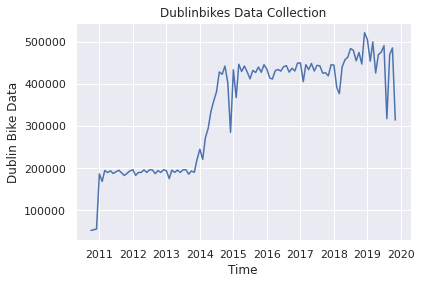

In [106]:
# Check number data entries for each year - for fixing some following issues later on.
diff1 = combined.groupby(['year','month'])
# pd.set_option("display.max_rows", None)
diff2 = diff1['bikes'].agg(['count'])['count'].reset_index(level=['year','month'])
diff3 = pd.to_datetime(diff2['year'].astype(str) + '/' + diff2['month'].astype(str))
plt.plot(list(diff3), list(diff2['count']))
plt.title('Dublinbikes Data Collection')
plt.xlabel('Time')
plt.ylabel('Dublin Bike Data');

# 2020 Dataset



In [107]:
# Load the dataset
data20 = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')
data20.drop(columns=['_id'], inplace=True)
data20.head()

,STATION ID,TIME,LAST UPDATED,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,STATUS,ADDRESS,LATITUDE,LONGITUDE
0,2,2020-01-01T06:25:02,2020-01-01T06:24:06,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814
1,2,2020-01-01T06:30:02,2020-01-01T06:24:06,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814
2,2,2020-01-01T06:35:02,2020-01-01T06:34:15,BLESSINGTON STREET,20,18,2,Open,Blessington Street,53.35677,-6.26814
3,2,2020-01-01T06:40:03,2020-01-01T06:37:22,BLESSINGTON STREET,20,20,0,Open,Blessington Street,53.35677,-6.26814
4,2,2020-01-01T06:45:02,2020-01-01T06:37:22,BLESSINGTON STREET,20,20,0,Open,Blessington Street,53.35677,-6.26814


####Exploratory Data Analysis on 2020 Dataset

**Missing station IDs:** 1, 14, 35, 46, 60, 70

In [109]:
pd.set_option("display.max_rows", None)
np.unique(data20['STATION ID'])

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  15,
        16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 117])

Missing data for the newly added Station # 117, **Hanover East Quay**. Data only available for 2 months and just for some random days within those 2 months. For January, only 4 days data is available and only 2nd February data is available. We cannot analyze the trend of this station with such incomplete and inconsistent data.

In [111]:
#checking data for station ID 117
data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')
data = data[data['STATION ID']==117]

data['TIME'] = pd.to_datetime(data['TIME'], format='%Y-%m-%d %H:%M:%S')

data['hour'] = pd.DatetimeIndex(data['TIME']).hour
data['day'] = pd.DatetimeIndex(data['TIME']).day
data['month'] = pd.DatetimeIndex(data['TIME']).month

result = data.groupby(['month', 'day', 'hour'])['AVAILABLE BIKES'].mean()
result = pd.DataFrame(result)
result = result.reset_index(level=['month', 'day', 'hour'])
result.head()

,month,day,hour,AVAILABLE BIKES
0,1,2,0,1.0
1,1,2,1,1.0
2,1,2,2,1.0
3,1,2,3,1.0
4,1,2,4,1.0


Bike Activity of Station 117 - A lot of missing data in the dataset

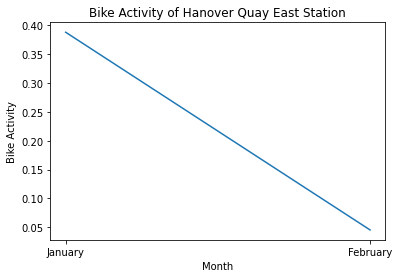

In [6]:
#visualize the latest added station number 117
#visualize in form of a time series
data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

data.drop(columns=['_id', 'LAST UPDATED', 'STATUS',	'ADDRESS',	'LATITUDE', 'LONGITUDE'], inplace=True)
data['TIME'] = pd.to_datetime(data['TIME'], format='%Y-%m-%d %H:%M:%S')

data = data[data['STATION ID']==117]
data['hour'] = pd.DatetimeIndex(data['TIME']).hour
data['day'] = pd.DatetimeIndex(data['TIME']).day
data['month'] = pd.DatetimeIndex(data['TIME']).month

#remove incorrect/bad samples
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] == 0) & (data['AVAILABLE BIKES'] == 0)].index)
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] + data['AVAILABLE BIKES']) != data['BIKE STANDS']].index)

result = data.groupby(['month'])['AVAILABLE BIKES'].apply(squared_row_difference)
result = pd.DataFrame(result)
result = result.reset_index(level=['month'])
result.rename(columns={'AVAILABLE BIKES':'Bike_Activity'}, inplace=True)

#removing outliers
mean = np.mean(result['Bike_Activity'], axis=0)
sd = np.std(result['Bike_Activity'], axis=0)
final_list = [x for x in result['Bike_Activity'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['Bike_Activity'].isin(final_list)]

result.dropna(inplace=True)
plt.xticks(np.arange(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Sepember', 'October', 'November', 'December'])  # Set text labels.
plt.plot(result['Bike_Activity'])
plt.title('Bike Activity of Hanover Quay East Station')
plt.xlabel('Month')
plt.ylabel('Bike Activity')
plt.show()

#### Data Analysis
Bike Activity Bar Plot of Dublin Stations - 2020

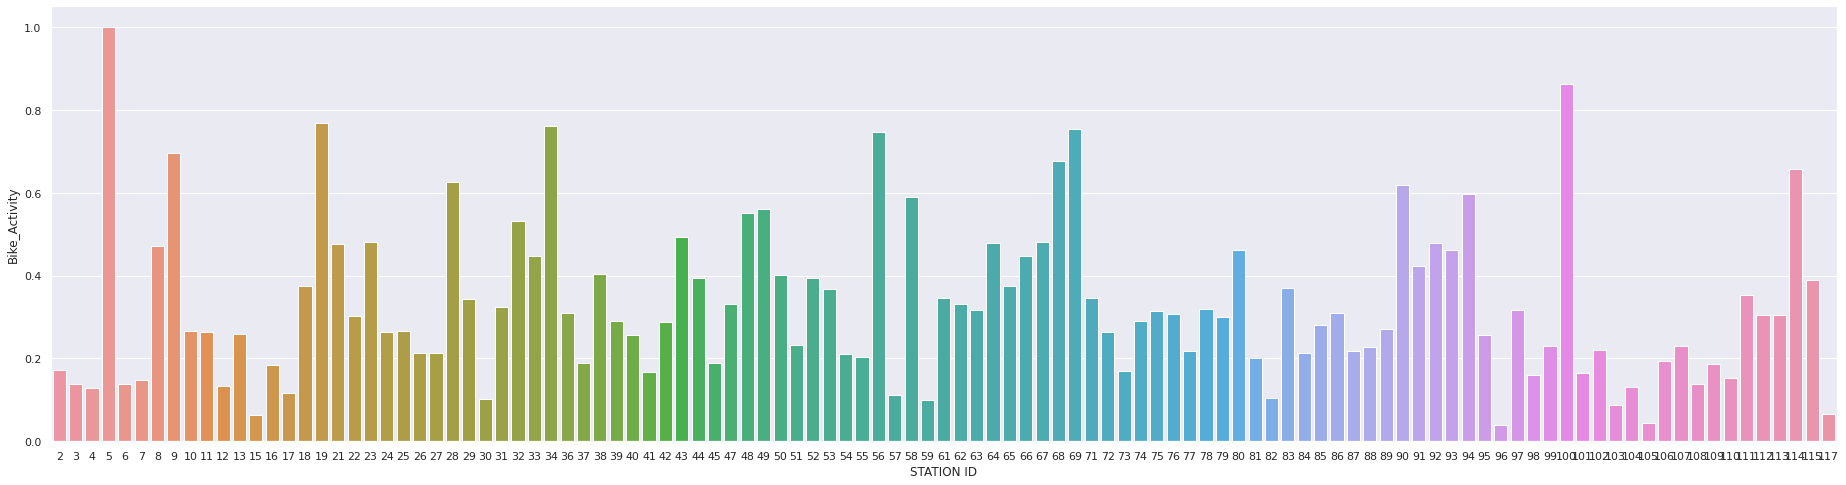

In [8]:
data20 = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')
# data20.sort_values('STATION ID')
data20.drop(columns=['_id'], inplace=True)

data20['TIME'] = pd.to_datetime(data20['TIME'], format='%Y-%m-%d %H:%M:%S')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

data20.sort_values(['STATION ID', 'TIME'])
result = data20.groupby('STATION ID')['AVAILABLE BIKES'].apply(squared_row_difference)
result = result/result.max()
result = pd.DataFrame(result)
result.reset_index(inplace=True)
result.rename(columns={'AVAILABLE BIKES':'Bike_Activity'}, inplace=True)

#activity bar plots of stations - 2020
sns.set(rc={'figure.figsize':(32,8)})
sns.barplot(x='STATION ID', y='Bike_Activity', data=result, order=result['STATION ID'])

Percentage bike availability in 2020

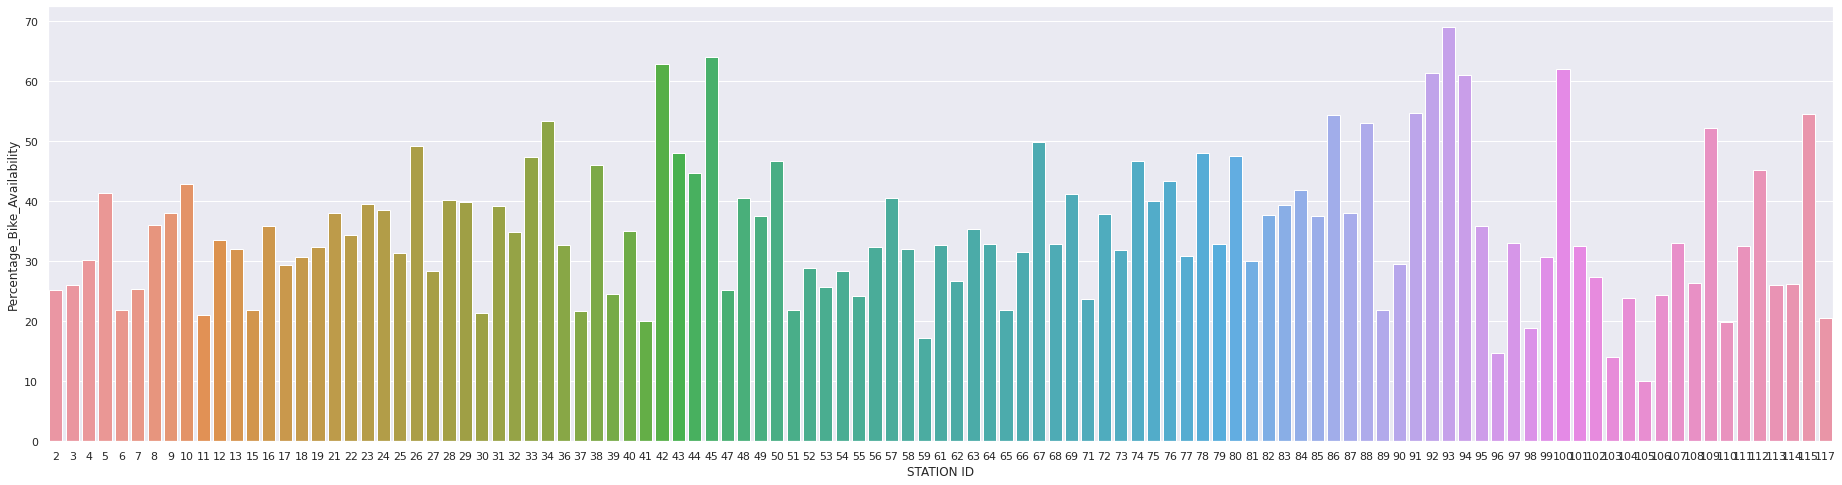

In [9]:
#visualize percentage bike availability of stations in 2020
station_data = data20.groupby(['STATION ID', 'NAME']).mean().reset_index()
# pd.set_option("display.max_rows", None)
station_data['Percentage_Bike_Availability'] = station_data['AVAILABLE BIKES']/station_data['BIKE STANDS'] * 100
station_data.sort_values('Percentage_Bike_Availability')

#plot the percentage bikes from above
sns.set(rc={'figure.figsize':(32,8)})
sns.barplot(x='STATION ID', y='Percentage_Bike_Availability', data=station_data)

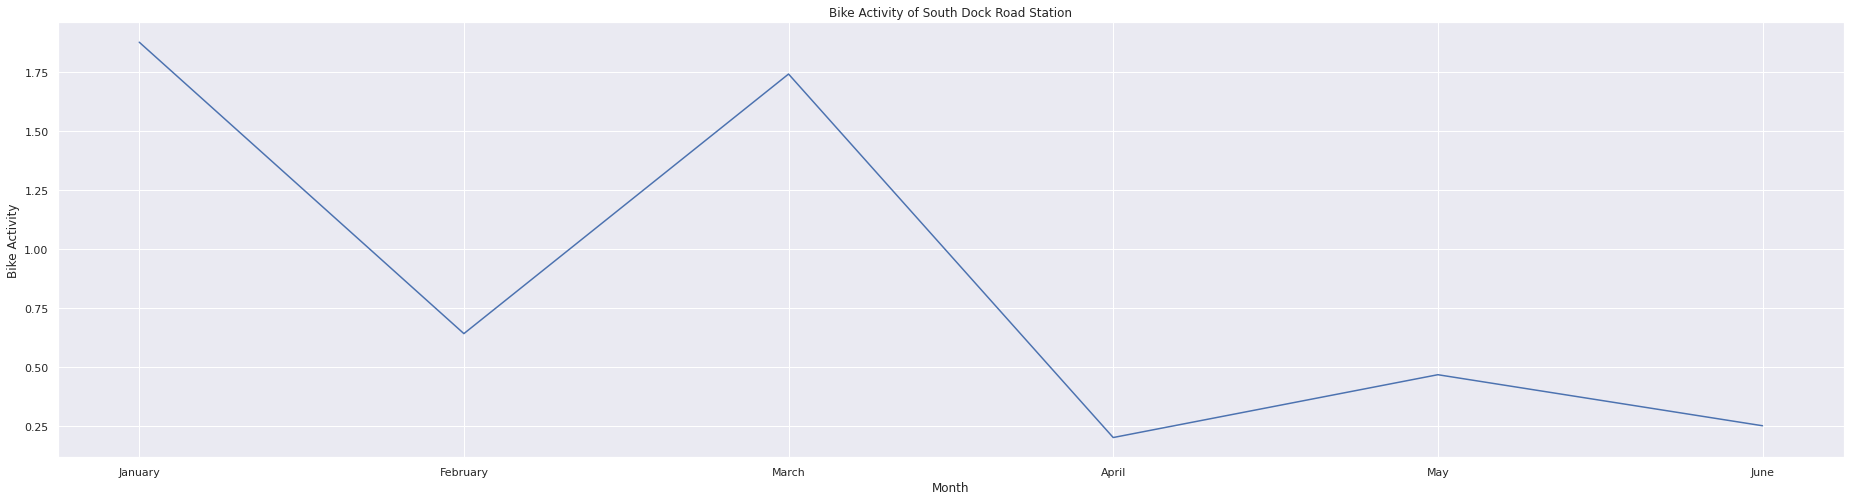

In [10]:
#visualize station number 91
#visualize in form of a time series
data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

data.drop(columns=['_id', 'LAST UPDATED', 'STATUS',	'ADDRESS',	'LATITUDE', 'LONGITUDE'], inplace=True)
data['TIME'] = pd.to_datetime(data['TIME'], format='%Y-%m-%d %H:%M:%S')

data = data[data['STATION ID']==91]
data['hour'] = pd.DatetimeIndex(data['TIME']).hour
data['day'] = pd.DatetimeIndex(data['TIME']).day
data['month'] = pd.DatetimeIndex(data['TIME']).month

#remove incorrect/bad samples
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] == 0) & (data['AVAILABLE BIKES'] == 0)].index)
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] + data['AVAILABLE BIKES']) != data['BIKE STANDS']].index)


result = data.groupby(['month'])['AVAILABLE BIKES'].apply(squared_row_difference)
result = pd.DataFrame(result)
result = result.reset_index(level=['month'])

#removing outliers
mean = np.mean(result['AVAILABLE BIKES'], axis=0)
sd = np.std(result['AVAILABLE BIKES'], axis=0)
final_list = [x for x in result['AVAILABLE BIKES'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['AVAILABLE BIKES'].isin(final_list)]

result.dropna(inplace=True)
result.rename(columns={'AVAILABLE BIKES':'Bike_Activity'}, inplace=True)

plt.xticks(np.arange(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Sepember', 'October', 'November', 'December'])  # Set text labels.
plt.plot(result['Bike_Activity'])
plt.title('Bike Activity of South Dock Road Station')
plt.xlabel('Month')
plt.ylabel('Bike Activity')
plt.show()

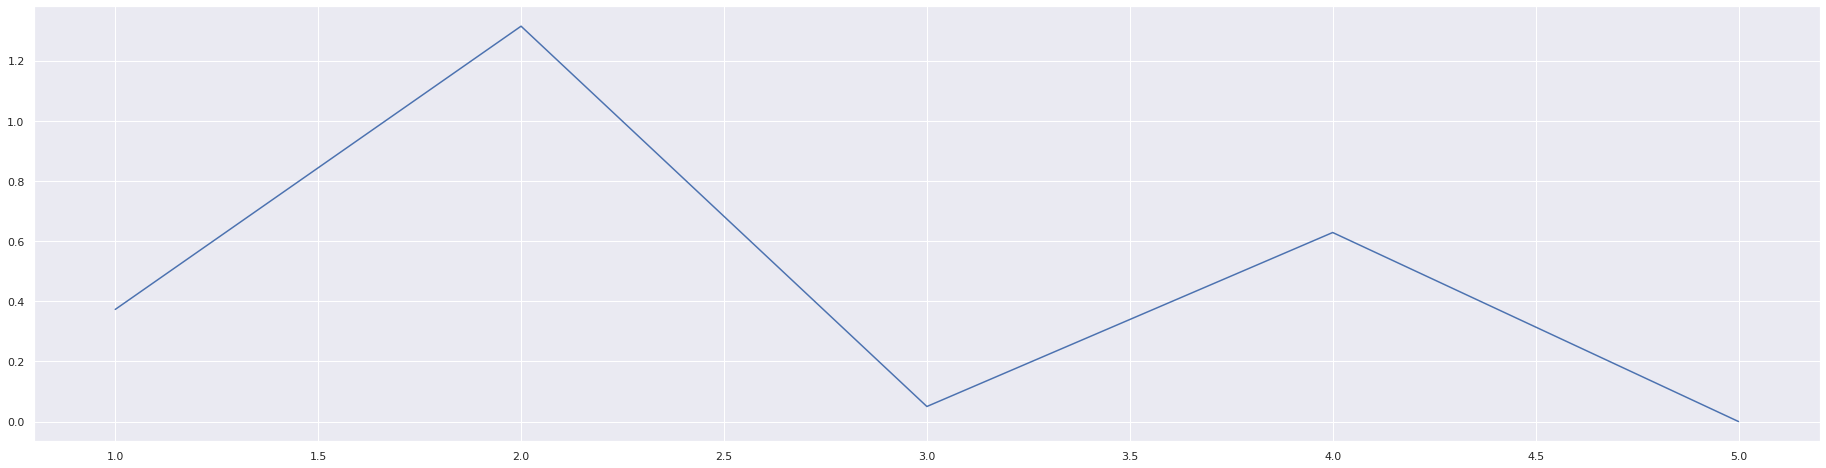

In [ ]:
#visualize station number 68
#visualize in form of a time series
data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

data.drop(columns=['_id', 'LAST UPDATED', 'STATUS',	'ADDRESS',	'LATITUDE', 'LONGITUDE'], inplace=True)
data['TIME'] = pd.to_datetime(data['TIME'], format='%Y-%m-%d %H:%M:%S')

data = data[data['STATION ID']==68]
data['hour'] = pd.DatetimeIndex(data['TIME']).hour
data['day'] = pd.DatetimeIndex(data['TIME']).day
data['month'] = pd.DatetimeIndex(data['TIME']).month

#remove incorrect/bad samples
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] == 0) & (data['AVAILABLE BIKES'] == 0)].index)
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] + data['AVAILABLE BIKES']) != data['BIKE STANDS']].index)


result = data.groupby(['month'])['AVAILABLE BIKES'].apply(squared_row_difference)
result = pd.DataFrame(result)
result = result.reset_index(level=['month'])

#removing outliers
mean = np.mean(result['AVAILABLE BIKES'], axis=0)
sd = np.std(result['AVAILABLE BIKES'], axis=0)
final_list = [x for x in result['AVAILABLE BIKES'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['AVAILABLE BIKES'].isin(final_list)]

result.rename(columns={'AVAILABLE BIKES':'Bike_Activity'}, inplace=True)

result.dropna(inplace=True)
plt.xticks(np.arange(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Sepember', 'October', 'November', 'December'])  # Set text labels.
plt.plot(result['Bike_Activity'])
plt.title('Bike Activity of Hanover Quay Station')
plt.xlabel('Month')
plt.ylabel('Bike Activity')
plt.show()

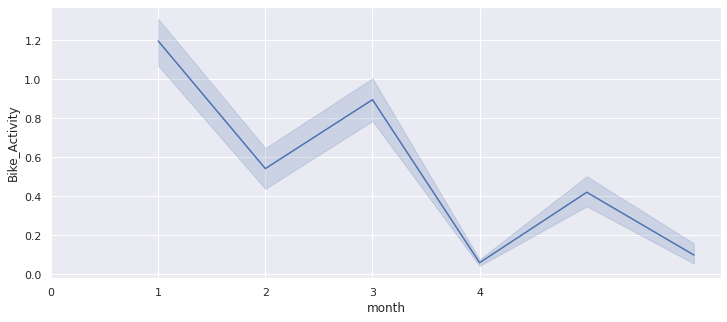

In [ ]:
#overall Dublin bike stations trend for 2020
data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/2020.csv')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

data.drop(columns=['_id', 'LAST UPDATED', 'STATUS',	'ADDRESS',	'LATITUDE', 'LONGITUDE'], inplace=True)
data['TIME'] = pd.to_datetime(data['TIME'], format='%Y-%m-%d %H:%M:%S')

data['hour'] = pd.DatetimeIndex(data['TIME']).hour
data['day'] = pd.DatetimeIndex(data['TIME']).day
data['month'] = pd.DatetimeIndex(data['TIME']).month

#remove incorrect/bad samples
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] == 0) & (data['AVAILABLE BIKES'] == 0)].index)
data = data.drop(data[(data['AVAILABLE BIKE STANDS'] + data['AVAILABLE BIKES']) != data['BIKE STANDS']].index)

result = data.groupby(['STATION ID', 'month'])['AVAILABLE BIKES'].apply(squared_row_difference)
result = pd.DataFrame(result)
result = result.reset_index()

#removing outliers
mean = np.mean(result['AVAILABLE BIKES'], axis=0)
sd = np.std(result['AVAILABLE BIKES'], axis=0)
final_list = [x for x in result['AVAILABLE BIKES'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['AVAILABLE BIKES'].isin(final_list)]

result.dropna(inplace=True)
result.rename(columns={'AVAILABLE BIKES':'Bike_Activity'}, inplace=True)

#plot
sns.set(rc={'figure.figsize':(12,5)})
g = sns.lineplot(x=result['month'], y=result['Bike_Activity'])
g.set_xticks(range(len(set('month')))) # <--- set the ticks first
plt.show()

The dropping bike activity after January explains the effect of COVID-19 pandemic.

# Holidays Trend

PyPi's Holiday library provides the holidays by country. The documentation provides a way to access each year's holidays individually, I am storing every year's holidays along with dates in a dataframe to create a custom holidays dataframe.

In [11]:
#creating holidays dataframe for Ireland from 2010-2020 using PyPi's holidays library
d = []
for year in range(2010,2021):
  for ptr in holidays.Ireland(years = year).items():
    d.append(ptr)

hol = pd.DataFrame(d)
hol.columns = ['timestamp', 'holiday']
hol
# hol.to_csv('/content/drive/My Drive/Dublin Bike Analysis/holidays.csv', index=False)
# hol = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/holidays.csv')

,timestamp,holiday
0,2010-01-01,New Year's Day
1,2010-03-17,St. Patrick's Day
2,2010-04-05,Easter Monday
3,2010-05-03,May Day
4,2010-06-07,June Bank Holiday
...,...,...
107,2020-08-03,Summer Bank Holiday
108,2020-10-26,October Bank Holiday
109,2020-12-25,Christmas Day
110,2020-12-26,Boxing Day


Next, I am merging the relevant holiday dates along with the bike activity of the Dublin stations on that day. This will allow us to visualize the bike activity of a station against different holidays.

Text(0, 0.5, 'Bike Activity')

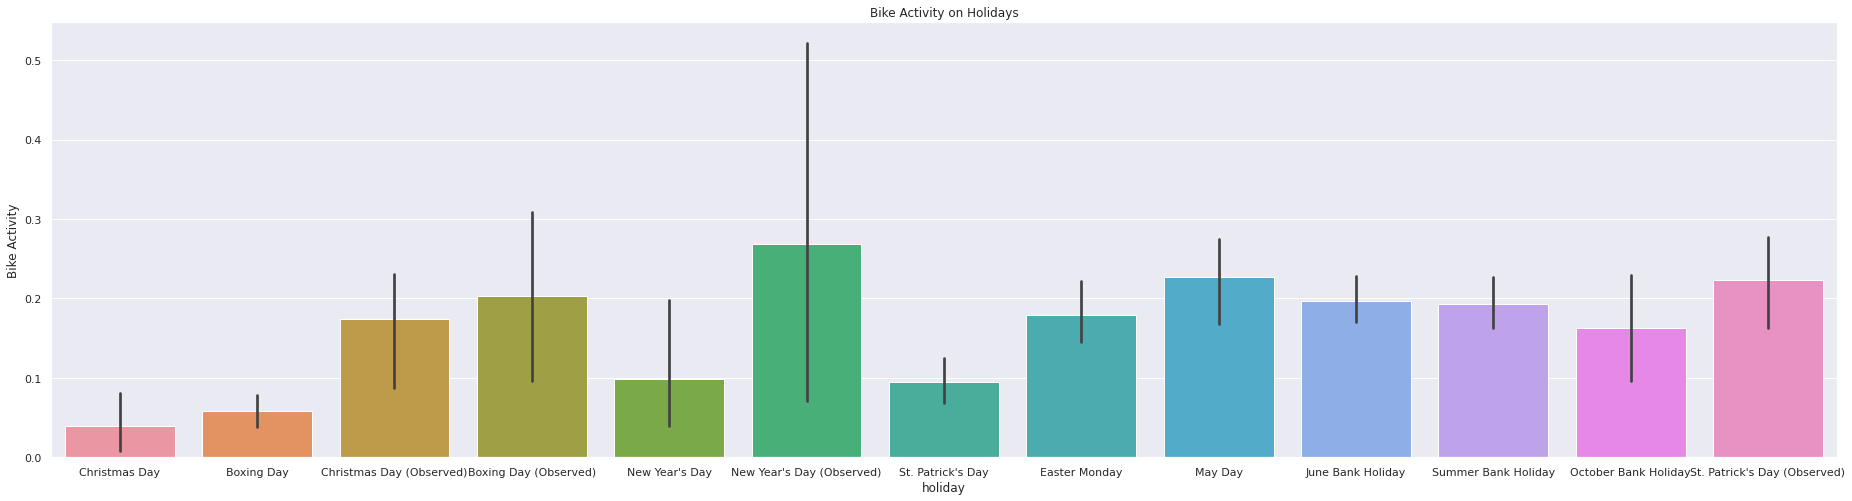

In [13]:
#visualize bike activity of a single station against holidays
hol = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
hol = hol[hol['tfl_id']==1]
hol['timestamp'] = pd.to_datetime(hol['timestamp'], format='%Y-%m-%d %H:%M:%S')
hol['day'] = pd.DatetimeIndex(hol['timestamp']).day

def squared_row_difference(x):
    # x = x.diff(periods=-1)
    return (x*x).mean()

hol['bikes'] = hol['bikes'].diff(periods=-1)
result = hol.groupby(['year','month', 'day'])['bikes'].apply(squared_row_difference)
result = pd.DataFrame(result)

# Splitting the multiindex into multiple dataframe columns after groupby
result = result.reset_index(level=['year','month', 'day'])
result.dropna(inplace=True)
result.rename(columns={'bikes':'bike_mean'}, inplace=True)
#combine year and month into timestamp
result['timestamp']=pd.to_datetime(result[['year','month','day']])

#removing outliers
mean = np.mean(result['bike_mean'], axis=0)
sd = np.std(result['bike_mean'], axis=0)
final_list = [x for x in result['bike_mean'] if (x > pd.eval(mean - 2 * sd))]
final_list = [x for x in final_list if (x < pd.eval(mean + 2 * sd))]
result = result[result['bike_mean'].isin(final_list)]

# Normalizing
result['bike_mean'] = result['bike_mean']/result['bike_mean'].max()

#read saved holiday dataframe
hol = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/holidays.csv')
hol['timestamp'] = pd.to_datetime(hol['timestamp'], format='%Y-%m-%d')

#sort for merging in next step
result.sort_values('timestamp', inplace=True)
hol.sort_values('timestamp', inplace=True)

#merge the the two dataframes
holiday_activity = pd.merge(result, hol)
holiday_activity.rename(columns = {'bike_mean': 'bike activity'}, inplace=True)

#plot the results
sns.set(rc={'figure.figsize':(32,8)})
ax = sns.barplot(x='holiday', y='bike activity', data=holiday_activity)
ax.set_title('Bike Activity on Holidays')
ax.set_ylabel('Bike Activity')

# Weather Trend

* **Station Name: Phoenix Park**
* **Station Height: 48m**
* **Location: Latitude:53.364  ,Longitude: -6.350**


* year:  -  Year
* month: -  Month
* rain:  -  Precipitation Amount (mm)
* meant: -  Mean Air Temperature (C)
* maxtp: -  Maximum Air Temperature (C)
* mintp: -  Minimum  Air Temperature (C)
* mnmax: -  Mean Maximum Temperature (C)
* mnmin: -  Mean Minimum Temperature (C)
* gmin:  -  Grass Minimum Temperature (C)
* wdsp:  -  Mean Wind Speed (knot)
* mxgt:  -  Highest Gust (knot)
* sun:   -  Sunshine duration (hours)
* ind:   -  Indicator






Loading the weather dataset


In [ ]:
weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')
# pd.set_option("display.max_rows", None)
weather

,year,month,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt,sun
0,2006,1,5.6,12.9,-4.7,8.8,2.5,16.7,-8.4,,,
1,2006,2,5.1,12.7,-3.8,8.2,1.9,37.0,-7.1,,,
2,2006,3,5.9,15.2,-6.3,9.3,2.6,70.3,-10.4,,,
3,2007,1,6.8,13.9,-1.2,9.5,4.1,70.5,-6.5,,,
4,2007,2,6.0,14.9,-5.1,9.6,2.4,61.2,-9.2,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
157,2019,12,6.3,14.2,-1.9,9.2,3.4,52.1,-6.3,,,
158,2020,1,6.6,14.2,-3.1,9.5,3.8,39.6,-7.8,,,
159,2020,2,6.2,13.8,-1.4,9.5,2.8,141.5,-6.1,,,
160,2020,3,6.6,16.1,-2.4,10.9,2.4,30.7,-7.3,,,


Preprocessing weather dataset

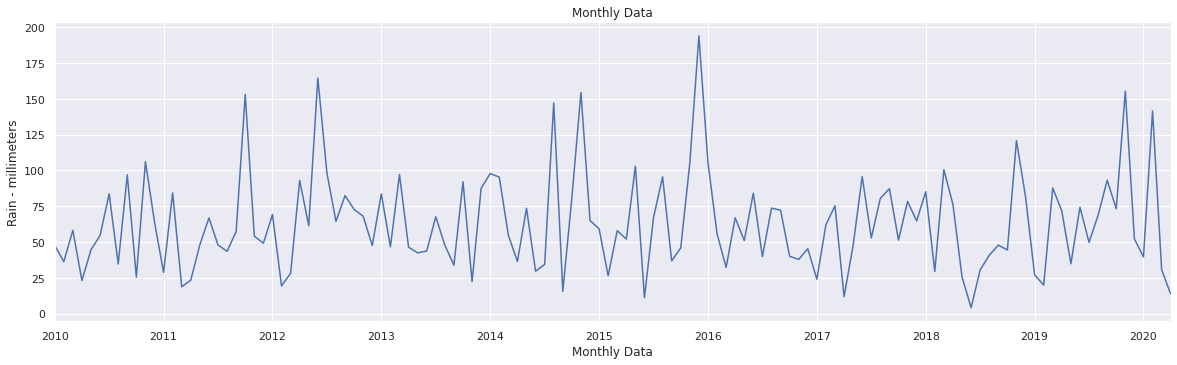

In [ ]:
weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')

#dropping samples before 2010 since they are not relevant for us
w = weather.drop(weather[weather.year < 2010].index)

#checking for any null values
w.isnull().sum()

# Extract out only the data we need for our analysis
w = w.loc[:, ['year', 'month', 'rain']].reset_index(drop=True)

#convert to float
w['rain'] = w['rain'].astype(str).astype(float)

#visualize in form of a time series
ax = w.set_index(pd.to_datetime(w[['year','month']].assign(day=1)))['rain'].plot(color='b', figsize=(20,5.5), title='Monthly Data')
_ = ax.set_xlabel('Monthly Data')
_ = ax.set_ylabel('Rain - millimeters')

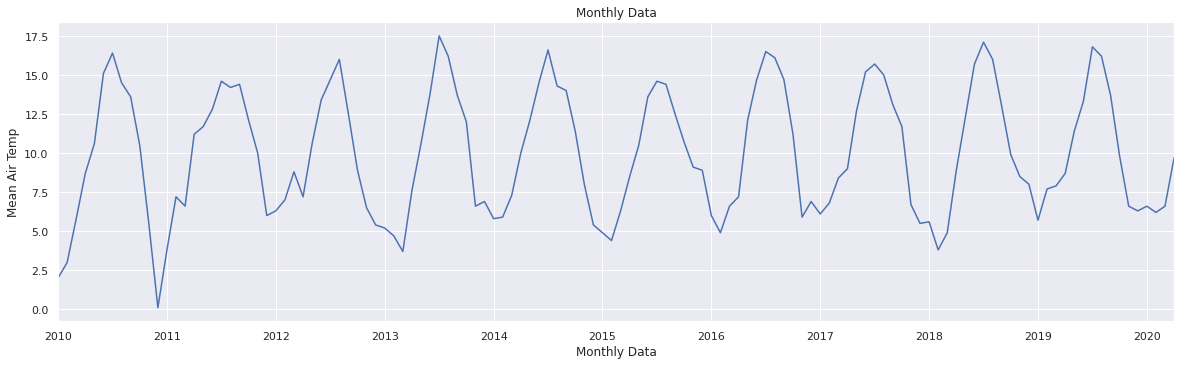

In [ ]:
weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')

# Removing irrelevant data
w = weather.drop(weather[weather.year < 2010].index)
w.isnull().sum()

# Extract out only the data we need
w = w.loc[:, ['year', 'month', 'meant']].reset_index(drop=True)
w['meant'] = w['meant'].astype(str).astype(float)

# Visualize
ax = w.set_index(pd.to_datetime(w[['year','month']].assign(day=1)))['meant'].plot(color='b', figsize=(20,5.5), title='Monthly Data')
_ = ax.set_xlabel('Monthly Data')
_ = ax.set_ylabel('Mean Air Temp')

# Bike Availability

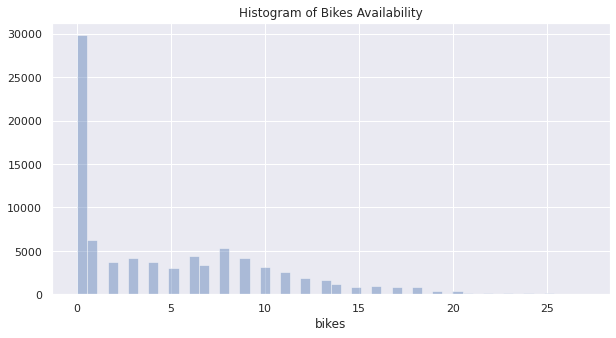

,tfl_id,bikes,spaces,total_docks,hour,day,month,year
count,83558.0,83558.000000,83558.000000,83558.000000,83558.000000,83558.000000,83558.000000,83558.000000
mean,104.0,4.781397,35.204935,39.986333,11.588872,3.007994,6.793317,2018.528866
std,0.0,5.347439,5.367688,0.430149,6.886135,2.007653,3.088753,0.499169
min,104.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2018.000000
25%,104.0,0.000000,32.000000,40.000000,6.000000,1.000000,4.000000,2018.000000
50%,104.0,3.000000,37.000000,40.000000,12.000000,3.000000,7.000000,2019.000000
75%,104.0,8.000000,40.000000,40.000000,18.000000,5.000000,9.000000,2019.000000
max,104.0,27.000000,47.000000,48.000000,23.000000,6.000000,12.000000,2019.000000


In [ ]:
# Exploring the bike availability of a least available station (Grangegorman station)
diff =  pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
df= diff[diff['tfl_id']==104]

# Checking for null values
#df.isnull().sum()
sns.set(rc={'figure.figsize':(10,5)})
sns.distplot(df.bikes, kde=False)
plt.title('Histogram of Bikes Availability')
plt.show();

Visualizing the percentage bike availability of stations for 2019

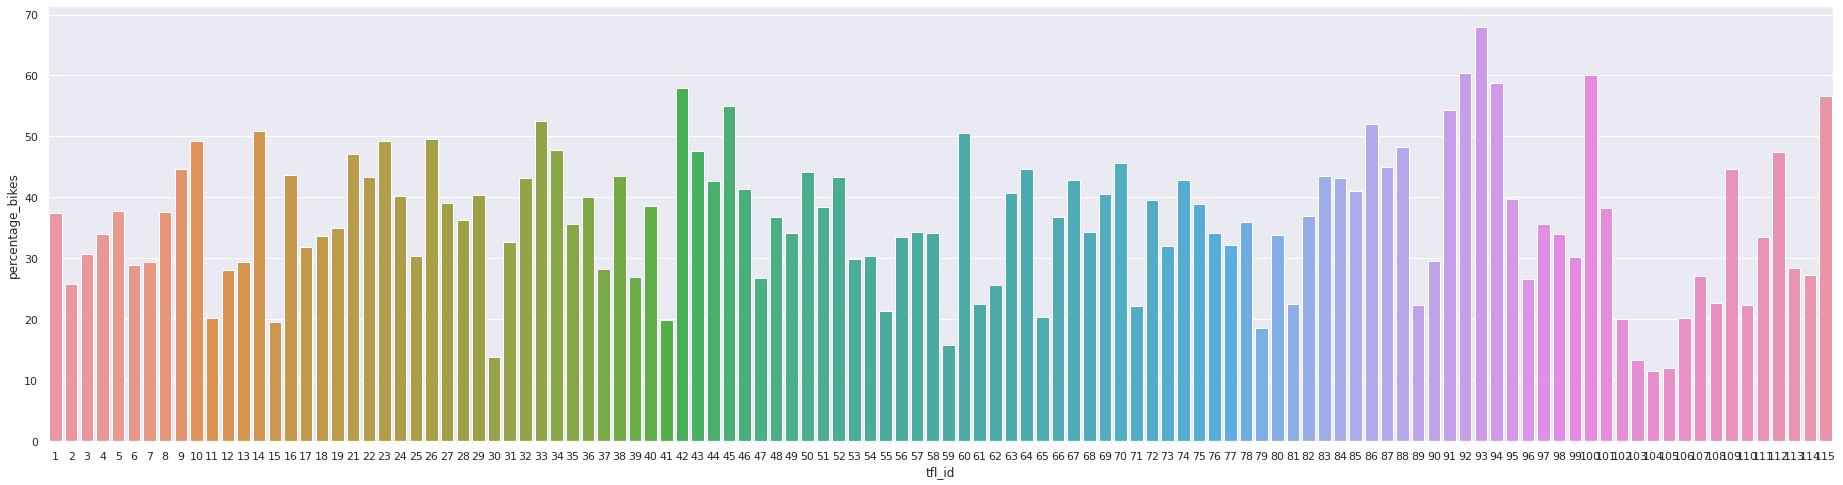

In [ ]:
d= pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
d= d[(d['total_docks']!=0) & (d['year']==2019)]
d['percentage_bikes'] = d.eval(('bikes/total_docks')) * 100
d = d.groupby('tfl_id')['percentage_bikes'].mean().reset_index()

#plot the percentage bikes from above
sns.set(rc={'figure.figsize':(32,8)})
sns.barplot(x='tfl_id', y='percentage_bikes', data=d, order = d['tfl_id'])

Clustering Analysis on Percentage Bike Availability

Silhouette Coefficient: 0.5446340544509567
CH score: 289.1781613878155


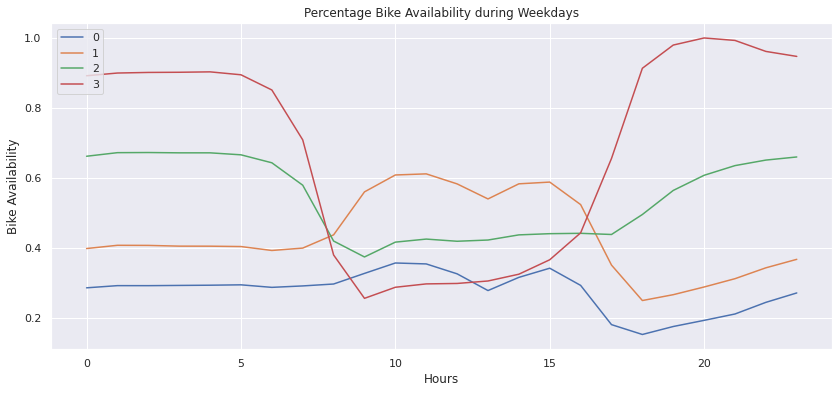

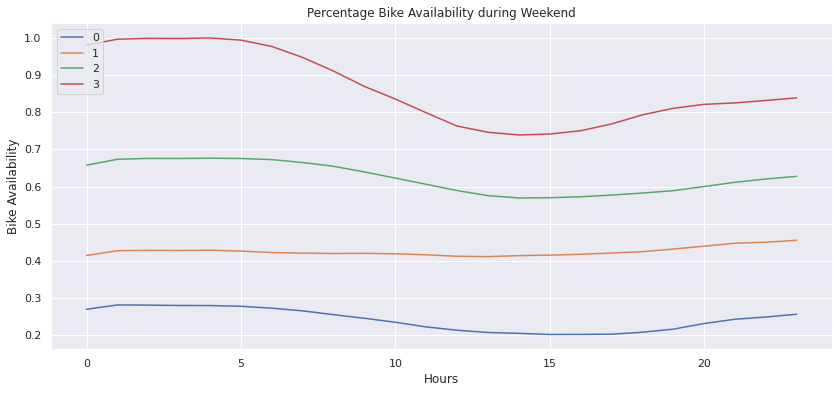

In [ ]:
#  Clustering Stations by their Bike Availability

combined = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
combined = combined[combined['total_docks']!=0]
combined['percentage_bikes'] = combined.eval(('bikes/total_docks')) * 100

# Fetch records by day, then by hour and then apply squared sum on bike difference
bike_availability = combined.groupby(['tfl_id','day', 'hour'])['percentage_bikes'].mean().reset_index()

# Clustering the stations based on their overall bike activities
station_cluster = pd.DataFrame(bike_availability.groupby('tfl_id')['percentage_bikes'].mean())

cluster_count = 4
clusters, centroids = kmeans1d.cluster(station_cluster['percentage_bikes'], cluster_count)

#check the evaluation coefficients for clustering
labels = clusters
x = station_cluster['percentage_bikes'].values.reshape(-1,1)
#silhouette coefficient
sil = metrics.silhouette_score(x, labels, metric = 'euclidean')
print("Silhouette Coefficient:", sil)
#CH score
ch = metrics.calinski_harabasz_score(x, labels)
print("CH score:", ch)

station_cluster['station_class'] = clusters

# Adding the cluster column against each station
bike_availability['station_class'] = bike_availability['tfl_id'].map(dict(station_cluster['station_class']))

#save the overall_bike_diff for output in next cell:
# overall_bike_diff.to_csv('/content/drive/My Drive/Dublin Bike Analysis/bike_availability_clusters.csv', index=False)

# # Filter weekdays
weekly_data = bike_availability[bike_availability['day']<5]
weekend_data = bike_availability[bike_availability['day']>4]

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = weekly_data.groupby(['station_class','hour'])['percentage_bikes'].mean()
weekend_data = weekend_data.groupby(['station_class','hour'])['percentage_bikes'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()
weekend_data = weekend_data/weekend_data.max()

# Plot the results for weekly data
plt.figure(figsize=(14,6))
for i in range(len(set(clusters))):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Availability during Weekdays')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()

# Plot the results for weekend
plt.figure(figsize=(14,6))
for i in range(cluster_count):
  plt.plot(weekend_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Percentage Bike Availability during Weekend')
plt.xlabel('Hours')
plt.ylabel('Bike Availability')
plt.show()

Regression Analysis on Bike Availability

In [ ]:
#regression on bike availability
d= pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
d= d[d['total_docks']!=0]
d['percentage_bikes'] = d.eval(('bikes/total_docks')) * 100
d = d.groupby(['tfl_id', 'year', 'month'])['percentage_bikes'].mean().reset_index()

#read the file and convert to appropriate format
bike_features = d.copy()

#input and output features
X = np.array(bike_features[['tfl_id','year','month']])
Y = bike_features['percentage_bikes']

#normalize
X = StandardScaler().fit_transform(X)

#create training and test sets
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)

names = ["Random Forest", "Support Vector", "Decision Trees", "Radius Neighbours", "Neural Net", "Extra Tree", "Bagging", "Gradient Boosting", "Hist Gradient Boosting", "Linear Regresion", "Ridge", "RidgeCV", "Baysian Ridge"]

regressors = [
               RandomForestRegressor(random_state=0),
               svm.SVR(),
               tree.DecisionTreeRegressor(),
               RadiusNeighborsRegressor(radius=1.0),
               MLPRegressor(alpha=0.01, random_state=1, max_iter=1000, learning_rate='adaptive'),
               ExtraTreeRegressor(),
               BaggingRegressor(),
               GradientBoostingRegressor(random_state=0),
               HistGradientBoostingRegressor(),
              linear_model.LinearRegression(),
             linear_model.Ridge(alpha=.5),
             linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)),
              linear_model.BayesianRidge()]

for name, regr in zip(names, regressors):
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  y_pred[y_pred<0] = 0
  print (name, " - R2 Score:", regr.score(x_test,y_test),"  - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)), "  - RMSLE :",np.sqrt(mean_squared_log_error( y_test, y_pred )))

Random Forest  - R2 Score: 0.8004140727226422   - RMSE: 5.331620538967093   - RMSLE : 0.1719577926077742
Support Vector  - R2 Score: 0.07512960905444988   - RMSE: 11.477167299894155   - RMSLE : 0.3445827952791808
Decision Trees  - R2 Score: 0.6726366354041133   - RMSE: 6.828248407646208   - RMSLE : 0.2077456810835471
Radius Neighbours  - R2 Score: 0.053420448130929055   - RMSE: 11.61108578016411   - RMSLE : 0.3493747113766598
Neural Net  - R2 Score: 0.07703278662529654   - RMSE: 11.46535248982644   - RMSLE : 0.34367594202053015
Extra Tree  - R2 Score: 0.3076416218638466   - RMSE: 9.930240121494263   - RMSLE : 0.31668113365288025
Bagging  - R2 Score: 0.7843660779220015   - RMSE: 5.541825100368298   - RMSLE : 0.17247971756696073
Gradient Boosting  - R2 Score: 0.5247695254489239   - RMSE: 8.227093166753392   - RMSLE : 0.26683937475621383
Hist Gradient Boosting  - R2 Score: 0.7248242627520046   - RMSE: 6.260360515037472   - RMSLE : 0.21240006840634443
Linear Regresion  - R2 Score: -0.00089

# Bike Activity

Calculating weekly bike activity values for Monday to Sunday to visualize on a heatmap later

In [2]:
#create weekly bike data difference column - here, we calculate the mean of hourly bike activity per week day (0-6) : without consideration of year
combined = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
weekly_bike_data = combined[['tfl_id', 'bikes', 'hour', 'day', 'timestamp']].copy()

weekly_bike_data.rename(columns={'day':'dayofweek'}, inplace=True)
weekly_bike_data.sort_values(['tfl_id', 'timestamp'], inplace=True)

weekly_bike_data['bikes_diff'] = weekly_bike_data['bikes'].diff(periods=-1)
mask = weekly_bike_data.tfl_id != weekly_bike_data.tfl_id.shift(-1)
weekly_bike_data['bikes_diff'][mask] = np.nan
weekly_bike_data['bikes_diff'] = weekly_bike_data['bikes_diff'] **2

grouped_multiple = weekly_bike_data.groupby(['tfl_id', 'dayofweek', 'hour'])['bikes_diff'].mean()
grouped_multiple = grouped_multiple/grouped_multiple.max()
grouped_multiple = grouped_multiple.reset_index()
# grouped_multiple.to_csv('/content/drive/My Drive/Dublin Bike Analysis/weekly_bike_diff.csv', index=False)
grouped_multiple.head()

,tfl_id,dayofweek,hour,bikes_diff
0,1,0,0,0.033120
1,1,0,1,0.016686
2,1,0,2,0.009842
3,1,0,3,0.026531
4,1,0,4,0.018527


Individual Station Bike Activity during the week - data for ~10 years period

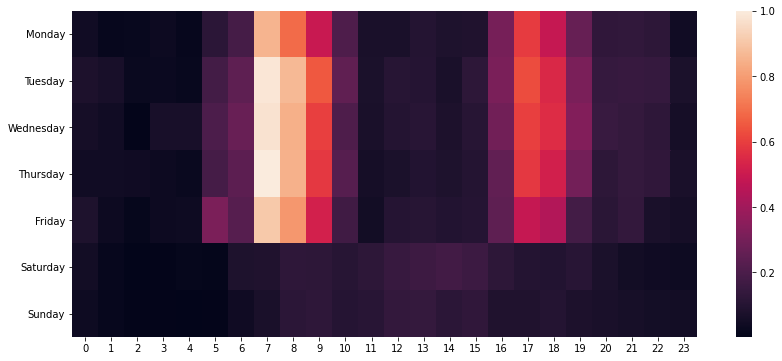

In [3]:
#loading the weekly_bike_diff file directly since it was saved in previous step
weekly_bike_data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/weekly_bike_diff.csv')
weekly_station_data = weekly_bike_data[weekly_bike_data['tfl_id']==5]

# Normalize bike difference values
weekly_station_data['bikes_difference'] = weekly_station_data['bikes_difference']/weekly_station_data['bikes_difference'].max()

final1 = pd.DataFrame()
# #for every single day (Mon-Sun), we should have an hourly bike-diff value on a flat list for heat map
final = weekly_station_data.groupby('dayofweek')['bikes_difference'].apply(list)
# print(final)

# #create values from 0-23 in form of a list of strings i.e ['0', '1',...'23']
cols = list(map(str, range(24)))

final1[cols] = pd.DataFrame(final.to_list(), index=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(14,6))
sns.heatmap(final1)

Calculating hourly bike activity of all Dublin stations for ~10-year period - hourly data of every day for each station


In [4]:
temporal_bike_data = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')

# temporal_bike_data = combined.copy()
temporal_bike_data['day'] = pd.DatetimeIndex(temporal_bike_data['timestamp']).day

def square_list(x):
  x = x.diff(periods=-1)
  return (x**2).mean(skipna=True)

temporal_bike_data.dropna(inplace=True)

# Fetch records by day, then by hour and then apply squared sum on bike difference
overall_bike_diff = temporal_bike_data.groupby(['tfl_id','day', 'hour'])['bikes'].apply(square_list)

# Normalize bike difference values
overall_bike_diff = overall_bike_diff/overall_bike_diff.max()

overall_bike_diff = overall_bike_diff.reset_index()
overall_bike_diff.rename(columns={'bikes': 'bikes_difference'}, inplace=True)
# overall_bike_diff.to_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv', index=False)
overall_bike_diff.head()

,tfl_id,day,hour,bikes_difference
0,1,1,0,0.177161
1,1,1,1,0.161115
2,1,1,2,0.167119
3,1,1,3,0.161626
4,1,1,4,0.161993


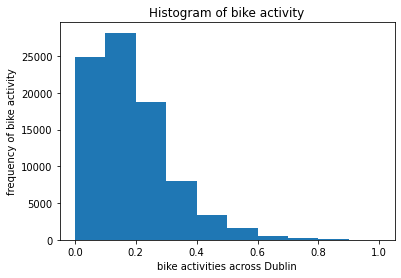

In [ ]:
#histogram of activity of Dublin bike stations
overall_bike_diff_hist = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv')

#skewed data - showing that mostly the stations have low activity level, and high activity is infrequent
plt.hist(overall_bike_diff_hist['bikes_difference'])

# Add title and axis names
plt.title('Histogram of bike activity')
plt.xlabel('bike activities across Dublin')
plt.ylabel('frequency of bike activity')
plt.show()

Applying 1d clustering to activity levels

In [ ]:
# Applying 1D clustering to activities (n different levels of activity)
overall_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv')
cluster_count = 3
clusters, centroids = kmeans1d.cluster(overall_bike_diff['bikes_difference'], cluster_count)

# Check the clustering evaluation metrics to decide on the optimal number of 'k' for k-means
labels = clusters
x = overall_bike_diff['bikes_difference'].values.reshape(-1,1)

# Silhouette coefficient
sil = metrics.silhouette_score(x, labels, metric = 'euclidean')
print("Silhouette Coefficient:", sil)

# CH score
ch = metrics.calinski_harabasz_score(x, labels)
print("CH score:", ch)

#printing to see which station falls in which clusters
# clustermap = overall_bike_diff
# clustermap['cluster'] = clusters
# clustermap
# cm = clustermap[['tfl_id', 'cluster']].copy().set_index('tfl_id')
# cm_final = cm.loc[~cm.index.duplicated(keep='first')]
# for tfl_id, cluster in cm_final.iterrows():
#   print("\n Station", tfl_id, "belongs to:", cluster)
# cm_final

Silhouette Coefficient: 0.5755484188413066
CH score: 240925.4496718998


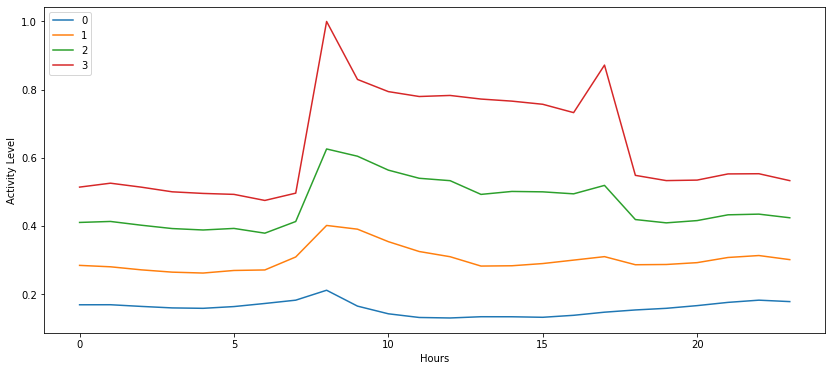

In [ ]:
#  Clustering Stations by their overall activity levels

overall_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv')

# Clustering the stations based on their overall bike activities
station_cluster = pd.DataFrame(overall_bike_diff.groupby('tfl_id')['bikes_difference'].mean())
cluster_count = 4
clusters, centroids = kmeans1d.cluster(station_cluster['bikes_difference'], cluster_count)
station_cluster['station_class'] = clusters

# Adding the cluster column against each station
overall_bike_diff['station_class'] = overall_bike_diff['tfl_id'].map(dict(station_cluster['station_class']))
#save the overall_bike_diff for output in next cell:
overall_bike_diff.to_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff_clusters.csv', index=False)

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = overall_bike_diff.groupby(['station_class','hour'])['bikes_difference'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()

# Plot the results for each cluster
plt.figure(figsize=(14,6))
for i in range(cluster_count)):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.xlabel('Hours')
plt.ylabel('Activity Level')
plt.title('Clustering Stations by their overall activity levels')
plt.show()

In [ ]:
# Prepare cluster dataframe
new = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff_clusters.csv')
new = new[['tfl_id', 'station_class']].copy()
new.drop_duplicates(['tfl_id'], keep='first', inplace=True)
new.reset_index(drop=True, inplace=True)

# Prepare station dataframe
bike_locations = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/bike_locations_processed.csv')
bike_locations = bike_locations[['tfl_id', 'operator_name', 'lat', 'lon']].copy()

# Merge cluster values with lat, lon and operator_name
merged = pd.merge(bike_locations, new)
merged.rename(columns={'station_class':'cluster'}, inplace=True)

# Folium Map
map_clusters = folium.Map(location=merged[['lat','lon']].mean().values.tolist(), zoom_start=14)

# Set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, cluster, operator_name in zip(merged['lat'], merged['lon'], merged['cluster'], merged['operator_name']):
    folium.vector_layers.CircleMarker(
        [lat, lon],
        radius=5,
        tooltip = str(operator_name) + ' - Cluster' + str(cluster),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters) 

map_clusters

Regression Analysis on Bike Activity

In [ ]:
#read the file and convert to appropriate format
bike_features = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff_clusters.csv')

#input and output features
X = np.array(bike_features[['tfl_id','hour','day']])
Y = bike_features['bikes_difference']

#normalize
X = StandardScaler().fit_transform(X)

#create training and test sets
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)

names = ["Random Forest", "Support Vector", "Decision Trees", "Radius Neighbours", "Neural Net", "Extra Tree", "Bagging", "Gradient Boosting", "Hist Gradient Boosting", "Linear Regresion", "Ridge", "RidgeCV", "Baysian Ridge"]

regressors = [
               RandomForestRegressor(random_state=0),
               svm.SVR(),
               tree.DecisionTreeRegressor(),
               RadiusNeighborsRegressor(radius=1.0),
               MLPRegressor(alpha=0.01, random_state=1, max_iter=1000, learning_rate='adaptive'),
               ExtraTreeRegressor(),
               BaggingRegressor(),
               GradientBoostingRegressor(random_state=0),
               HistGradientBoostingRegressor(),
              linear_model.LinearRegression(),
             linear_model.Ridge(alpha=.5),
             linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)),
              linear_model.BayesianRidge()]

for name, regr in zip(names, regressors):
  regr.fit(x_train, y_train)
  y_pred = regr.predict(x_test)
  y_pred[y_pred<0] = 0
  print (name, " - R2 Score:", regr.score(x_test,y_test),"  - RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)), "  - RMSLE :",np.sqrt(mean_squared_log_error( y_test, y_pred )))

Random Forest  - R2 Score: 0.9591428216787046   - RMSE: 0.025809237657603724   - RMSLE : 0.020377009273926987
Support Vector  - R2 Score: 0.10721003802532647   - RMSE: 0.12064675380590126   - RMSLE : 0.09578383748843113
Decision Trees  - R2 Score: 0.9378511110735583   - RMSE: 0.0318315419036605   - RMSLE : 0.02518869268313845
Radius Neighbours  - R2 Score: 0.08758466684543931   - RMSE: 0.12196557825692167   - RMSLE : 0.09716431285434775
Neural Net  - R2 Score: 0.15334618455551086   - RMSE: 0.11748811247187396   - RMSLE : 0.09355128086155597
Extra Tree  - R2 Score: 0.8698854698641578   - RMSE: 0.046057874340195294   - RMSLE : 0.036239172260936474
Bagging  - R2 Score: 0.9550112739747486   - RMSE: 0.027082754892779008   - RMSLE : 0.021385740224462647
Gradient Boosting  - R2 Score: 0.47469131037468904   - RMSE: 0.09254400366718418   - RMSLE : 0.07333591299327143
Hist Gradient Boosting  - R2 Score: 0.8270409847619435   - RMSE: 0.053102209728256446   - RMSLE : 0.042358496692422205
Linear Reg

From the results below, it can be see that there are a lot of activity level variations and fluctuations in each cluster. For example, in cluster 0, there is low activity level and less fluctuation. In cluster 3, fluctuation and activity level is high. Fluctuation basically shows the change in activity, showing the business of a station. For cluster 1 and 2, overall activity level is high but fluctuation is less, which means they're busy most of the time and their behavior is constant.

Silhouette Coefficient: 0.8083605648179877
CH score: 29738.18949872443


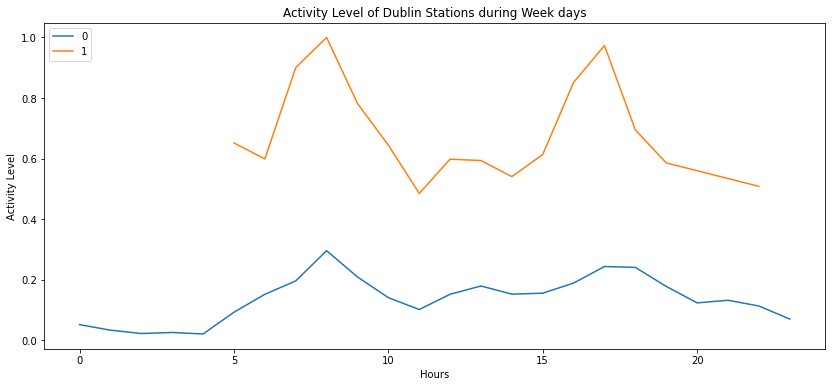

In [ ]:
# Hourly trend of each cluster on week days
weekly_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/weekly_bike_diff.csv')

# Clustering the stations based on their overall bike activities
cluster_count = 2
clusters, centroids = kmeans1d.cluster(weekly_bike_diff['bikes_difference'], cluster_count)

#check the coefficient values
labels = clusters
x = weekly_bike_diff['bikes_difference'].values.reshape(-1,1)
sil = metrics.silhouette_score(x, labels, metric = 'euclidean')
print("Silhouette Coefficient:", sil)
ch = metrics.calinski_harabasz_score(x, labels)
print("CH score:", ch)

# Adding the cluster column against each station
weekly_bike_diff['bike_class'] = clusters

# Filter weekdays
weekly_bike_diff = weekly_bike_diff[weekly_bike_diff['dayofweek']<5]

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = weekly_bike_diff.groupby(['bike_class','hour'])['bikes_difference'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()

# Plot the results for each cluster
plt.figure(figsize=(14,6))
for i in range(cluster_count):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Activity Level of Dublin Stations during Week days')
plt.xlabel('Hours')
plt.ylabel('Activity Level')
plt.show()

On weekends, we can see that cluster 1 stations are again being used extensively. They show extremely high bike activity or fluctuations. This shows cluster 1 may be in the city center, since city center stations are also used extensively on weekends due to short trips within commercial areas etc.

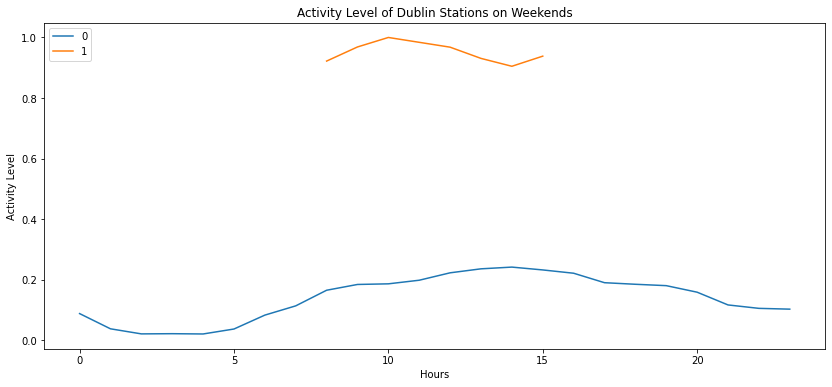

In [ ]:
# Hourly trend of each cluster on weekend
weekly_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/weekly_bike_diff.csv')

# Clustering the stations based on their overall bike activities
cluster_count = 2
clusters, centroids = kmeans1d.cluster(weekly_bike_diff['bikes_difference'], cluster_count)

# Adding the cluster column against each station
weekly_bike_diff['bike_class'] = clusters

# Filter weekdays
weekly_bike_diff = weekly_bike_diff[weekly_bike_diff['dayofweek']>4]

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = weekly_bike_diff.groupby(['bike_class','hour'])['bikes_difference'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()

# Plot the results for each cluster
plt.figure(figsize=(14,6))
for i in range(cluster_count):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Activity Level of Dublin Stations on Weekends')
plt.xlabel('Hours')
plt.ylabel('Activity Level')
plt.show()

Silhouette Coefficient: 0.6121602881972288
CH score: 150883.32870704515


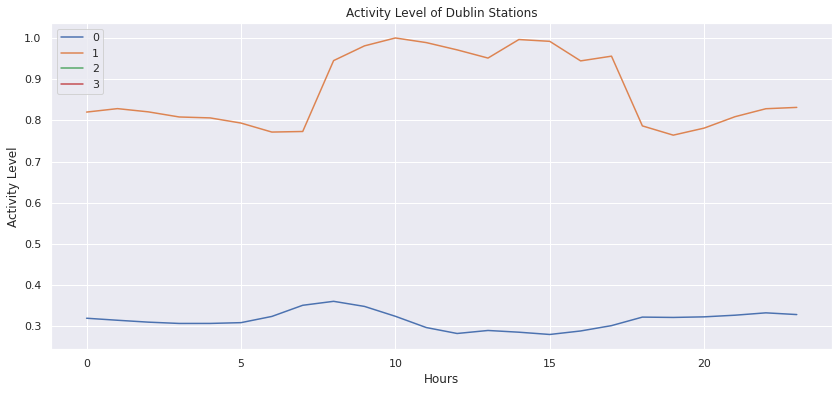

In [ ]:
# Clustering the stations based on their overall bike activities - without consideration of year, tfl_id, day etc.
overall_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv')
cluster_count = 2
clusters, centroids = kmeans1d.cluster(overall_bike_diff['bikes_difference'], cluster_count)

#check the coefficient values
labels = clusters
x = overall_bike_diff['bikes_difference'].values.reshape(-1,1)
sil = metrics.silhouette_score(x, labels, metric = 'euclidean')
print("Silhouette Coefficient:", sil)
ch = metrics.calinski_harabasz_score(x, labels)
print("CH score:", ch)

# Adding the cluster column against each station
overall_bike_diff['bike_class'] = clusters

# Group by clusters first, then by hours, then adding all the activity values
weekly_data = overall_bike_diff.groupby(['bike_class','hour'])['bikes_difference'].mean()

# Normalizing the grouped results
weekly_data = weekly_data/weekly_data.max()

# Plot the results for each cluster
plt.figure(figsize=(14,6))
for i in range(cluster_count):
  plt.plot(weekly_data[i], label=i)

plt.legend(loc='upper left', frameon=True)
plt.title('Activity Level of Dublin Stations')
plt.xlabel('Hours')
plt.ylabel('Activity Level')
plt.show()

In [ ]:
1. #Applying classification to clusters
overall_bike_diff = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/overall_bike_diff.csv')
overall_bike_diff = overall_bike_diff.apply(pd.to_numeric)

# Clustering the stations based on their overall bike activities
cluster_count = 3
clusters, centroids = kmeans1d.cluster(overall_bike_diff['bikes_difference'], cluster_count)

# overall_bike_diff.dtypes
X = np.array(overall_bike_diff[['tfl_id','hour','day']])
Y = clusters

# scale our values to give them all equal importance. Scaling is also important from a clustering perspective as the distance between points affects the way clusters are formed.
X = StandardScaler().fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)
print("X_train has these samples:", x_train.shape)
print("X_test has these samples:", x_test.shape)
print("Y_train has these samples:", len(y_train))
print("Y_train has these samples:", len(y_test))

X_train has these samples: (68448, 3)
X_test has these samples: (17112, 3)
Y_train has these samples: 68448
Y_train has these samples: 17112


Nearest Neighbors
% Accuracy: 54.27185600748013
Precision Score 0.5239276012243391
Recall Score 0.5427185600748013
F1-Score Score 0.5277676265143075
Computing cross-validated metrics..
Scores: [0.53184899 0.11623422 0.15877747 0.16362786 0.51718093]
mean score and 95% confidence interval of the score estimate are given by
Accuracy: 0.30 (+/- 0.37)
Linear SVM
% Accuracy: 53.2608695652174
Precision Score 0.532608695652174
Recall Score 0.532608695652174
F1-Score Score 0.6950354609929079
Computing cross-validated metrics..
Scores: [0.53179056 0.53179056 0.53179056 0.53179056 0.53179056]
mean score and 95% confidence interval of the score estimate are given by
Accuracy: 0.53 (+/- 0.00)
RBF SVM
% Accuracy: 60.320243104254324
Precision Score 0.5924219525492668
Recall Score 0.6032024310425432
F1-Score Score 0.6197715375075497
Computing cross-validated metrics..
Scores: [0.53179056 0.10366994 0.16637447 0.31819776 0.525187  ]
mean score and 95% confidence interval of the score estimate are give

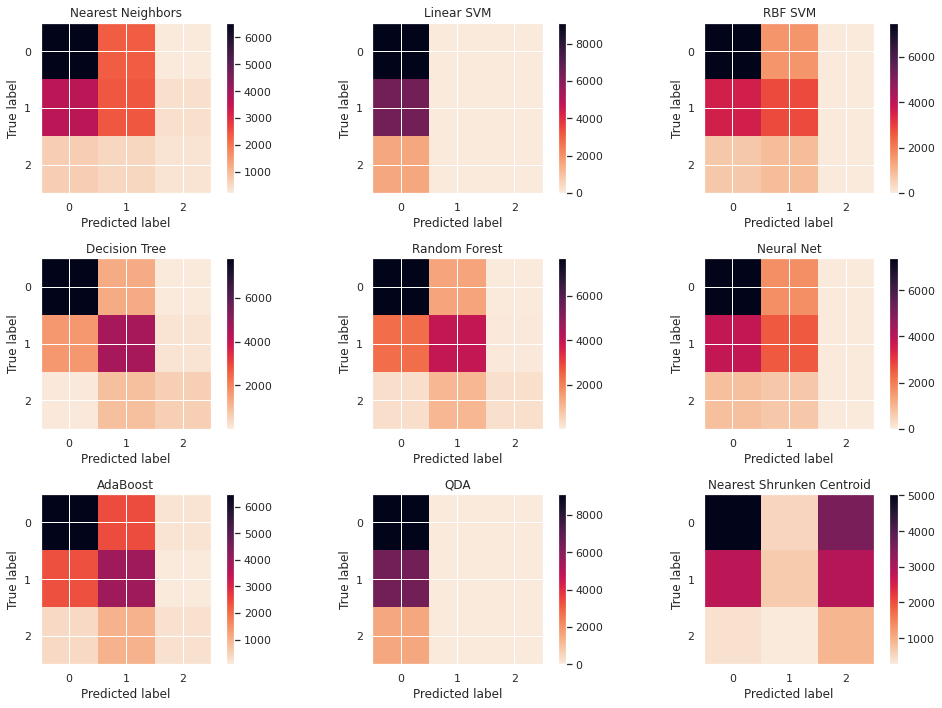

In [ ]:
2. #run different classifiers in loop and print scores
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "QDA", "Nearest Shrunken Centroid", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis(),
    NearestCentroid(shrink_threshold= 0.2),
    LogisticRegression(random_state=0)]

for name, clf in zip(names, classifiers):
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  print (name)
  print("% Accuracy:",metrics.accuracy_score(y_test, y_pred) * 100)
  print("Precision Score", metrics.precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
  print("Recall Score", metrics.recall_score(y_test, y_pred, average='weighted'))
  print("F1-Score Score", metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))

  print("Computing cross-validated metrics..")
  #computing the score 5 consecutive times (with different splits each time)
  scores = cross_val_score(clf, X, Y, cv=5) #By default, the score computed at each CV iteration is the score method of the estimator
  print("Scores:", scores)
  print ("mean score and 95% confidence interval of the score estimate are given by")
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
for cls, ax, name in zip(classifiers, axes.flatten(), names):
    plot_confusion_matrix(cls, x_test, y_test, ax=ax, values_format=None, cmap=sns.cm.rocket_r, include_values=False)
    ax.title.set_text(name)

plt.tight_layout()
plt.grid(None)
plt.show()

% Accuracy: 91.57706093189965
Precision Score 0.9156044763597442
Recall Score 0.9157706093189965
F1-Score Score 0.9156749489425997

Computing cross-validated metrics..
Scores: [0.54032258 0.07217158 0.09081346 0.03319308 0.54663394]
mean score and 95% confidence interval of the score estimate are given by
Accuracy: 0.26 (+/- 0.47)


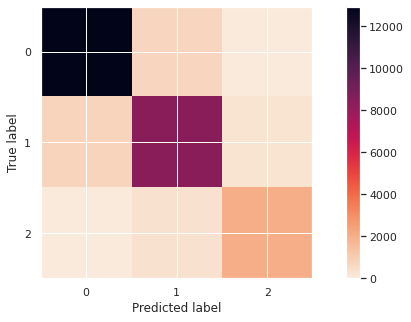

In [ ]:
3. #Checking for 1 classifier here for quick testing
X = StandardScaler().fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

# clf = KNeighborsClassifier(weights = 'distance')
# clf = SVC(kernel="linear", class_weight='balanced') #Linear SVM
# clf = SVC(gamma=2, C=1)
# clf = DecisionTreeClassifier()
clf = RandomForestClassifier(random_state=0, class_weight = 'balanced', max_features=3)
# clf =  MLPClassifier(max_iter=1000)
# clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# clf = QuadraticDiscriminantAnalysis()
# clf = NearestCentroid(shrink_threshold= 0.2)
# clf = LogisticRegression(random_state=0)

#Train the model using the training sets
clf.fit(x_train, y_train)

#perdiction on test set
y_pred = clf.predict(x_test)

# Validation Metrics
print("% Accuracy:",metrics.accuracy_score(y_test, y_pred) * 100)
print("Precision Score", metrics.precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))
print("Recall Score", metrics.recall_score(y_test, y_pred, average='weighted'))
print("F1-Score Score", metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred)))

# Cross Validation Metrics
print("\nComputing cross-validated metrics..")
#computing the score 5 consecutive times (with different splits each time)
scores = cross_val_score(clf, X, Y, cv=5) #By default, the score computed at each CV iteration is the score method of the estimator
print("Scores:", scores)
print ("mean score and 95% confidence interval of the score estimate are given by")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Confusion Matrix
plot_confusion_matrix(clf, x_test, y_test, values_format=None, cmap=sns.cm.rocket_r, include_values=False)

some labels in y_true don't appear in y_pred. This means that there is no F-score to calculate for this label, and thus the F-score for this case is considered to be 0.0. Since you requested an average of the score, you must take into account that a score of 0 was included in the calculation, and this is why scikit-learn is showing you a warning. not interested in the scores of labels that were not predicted, and then explicitly specify the labels you are interested in (which are labels that were predicted at least once). Thus we use labels=np.unique(y_pred) for calculating F1 score. 

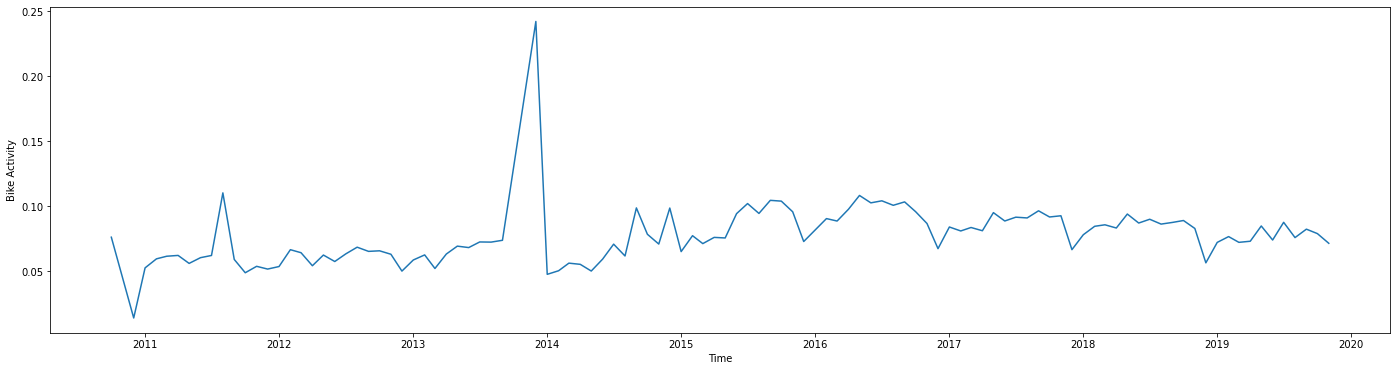

In [ ]:
#Time series plot for Activity fluctuation over the years - in general all Dublin stations - begin from here.
grouped_activity = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x**2).mean(skipna=True)

# Calculating monthly bike activity for each station over the years
result = grouped_activity.groupby(['tfl_id','year','month'])['bikes'].apply(squared_row_difference)

# Splitting the multiindex into multiple dataframe columns
result = result.reset_index(level=['year','month','tfl_id'])

# # Combining monthly bike activity for all stations over the years
result = result.groupby(['year','month'])['bikes'].mean()

# Normalizing
result = result/result.max()

# Splitting the multiindex into multiple dataframe columns again
result = result.reset_index(level=['year','month'])

#filtering outliers 
mean = np.mean(result['bikes'], axis=0)
sd = np.std(result['bikes'], axis=0)
final_list = [x for x in result['bikes'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['bikes'].isin(final_list)]

# Combine month and year into a single timestamp column (to display on plot)
result['timestamp'] = pd.to_datetime(result['year'].astype(str) + '/' + result['month'].astype(str))

# Plot the bike actvities time series
plt.figure(figsize=(24,6))

plt.plot(list(result['timestamp']), list(result['bikes']))
plt.xlabel('Time')
plt.ylabel('Bike Activity')
plt.show()

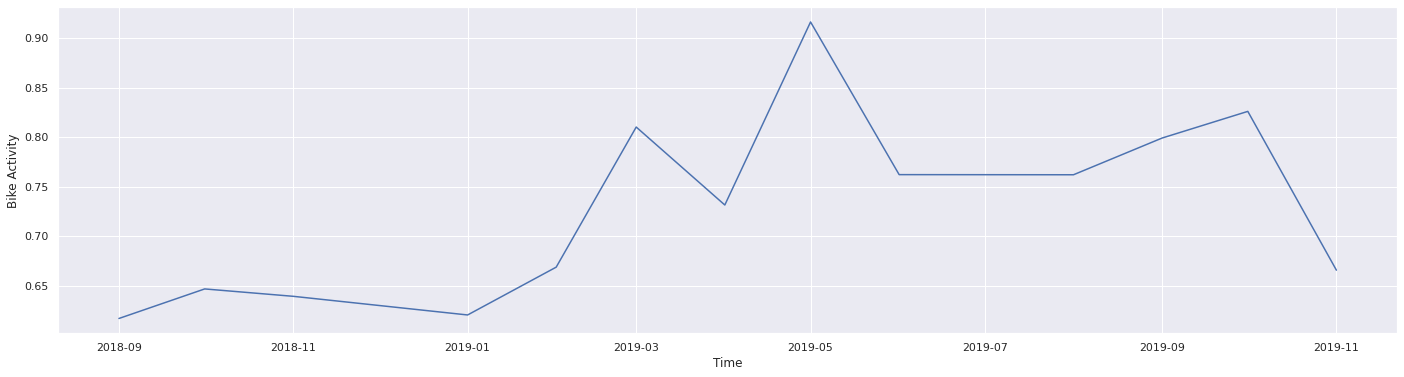

In [ ]:
1. #Time series plot for Activity fluctuation over the years - per station
grouped_activity = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
grouped_activity = grouped_activity[grouped_activity['tfl_id']==115]

def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x**2).mean(skipna=True)

# Calculating monthly bike activity for each station over the years
result = grouped_activity.groupby(['tfl_id','year','month'])['bikes'].apply(squared_row_difference)

# Splitting the multiindex into multiple dataframe columns
result = result.reset_index(level=['year','month','tfl_id'])

# Combining monthly bike activity for all stations over the years
result = result.groupby(['year','month'])['bikes'].mean()

# Normalizing
result = result/result.max()

# Splitting the multiindex into multiple dataframe columns again
result = result.reset_index(level=['year','month'])

#filtering outliers 
mean = np.mean(result['bikes'], axis=0)
sd = np.std(result['bikes'], axis=0)
final_list = [x for x in result['bikes'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
result = result[result['bikes'].isin(final_list)]

# Combine month and year into a single timestamp column (to display on plot)
result['timestamp'] = pd.to_datetime(result['year'].astype(str) + '/' + result['month'].astype(str))
result.dropna(inplace=True)

# Plot the bike actvities time series
plt.figure(figsize=(24,6))

plt.plot(list(result['timestamp']), list(result['bikes']))
plt.xlabel('Time')
plt.ylabel('Bike Activity')
plt.show()
# result

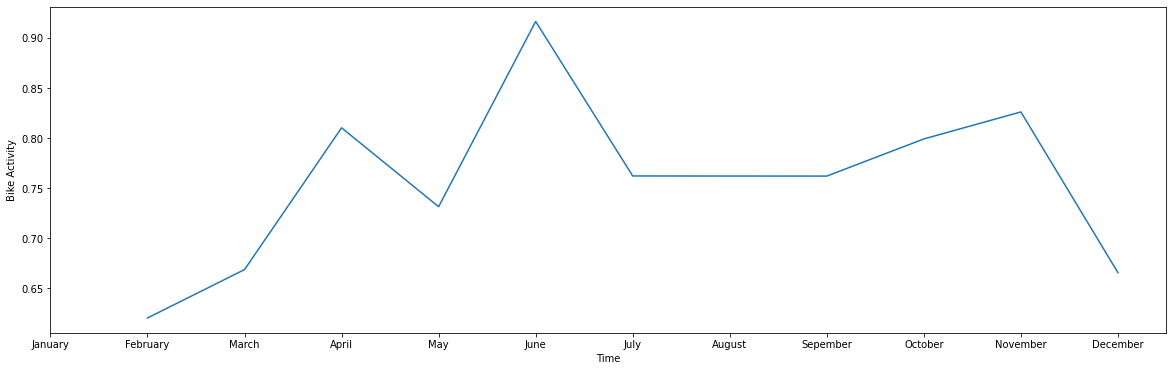

In [ ]:
2. #for getting monthly trend, run the above cell & specify year
result = result[result['year']==2019]

#Plot the bike actvities time series
plt.figure(figsize=(20,6))

plt.plot(list(result['month']), list(result['bikes']))
plt.xlabel('Time')
plt.xticks(np.arange(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Sepember', 'October', 'November', 'December'])  # Set text labels.
plt.ylabel('Bike Activity')
plt.show()

In [5]:
1. #Plot Wind and Bike Activity - Run the following code cells related to air temperature and rain in sequence
weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')

#prepare activity data for any station
grouped_activity = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
grouped_activity = grouped_activity[grouped_activity['tfl_id']==1]
grouped_activity['bikes_difference'] = grouped_activity['bikes'].diff(periods=-1)
grouped_activity.dropna(inplace=True)

#skipping data before 2010 since we only need to see the trend with bike activity from 2010 onward
wind = weather.drop(weather[weather.year < 2010].index)

#checking for null values
wind.isnull().sum()

# Extract needed samples from data
wind = wind.loc[:, ['year', 'month', 'meant']].reset_index(drop=True)
wind['meant'] = wind['meant'].astype(str).astype(float)

activity = grouped_activity[['timestamp', 'year', 'month', 'bikes_difference']].copy()
values = np.power(activity['bikes_difference'], 2)
activity['bikes_difference'] = values

#convert to datetime
activity['timestamp'] = pd.to_datetime(activity['timestamp'], format='%Y-%m-%d %H:%M:%S')

#combine year and month into timestamp and assign day=1 to each sample since we do not care about the day
wind['timestamp'] = pd.to_datetime(wind[['year','month']].assign(day=1)).dt.to_period('D')
wind.sort_values('timestamp', inplace=True)
activity.sort_values('timestamp', inplace=True)

#rectify the index
activity.reset_index(drop='True', inplace=True)

# data = wind.groupby('year')['meant'].mean().reset_index()
B1 = activity.groupby(['year' ,'month'])['bikes_difference'].mean()
B1 = pd.DataFrame(B1)
B1.reset_index(inplace=True)

#removing outliers
mean = np.mean(B1['bikes_difference'], axis=0)
sd = np.std(B1['bikes_difference'], axis=0)
final_list = [x for x in B1['bikes_difference'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
B1 = B1[B1['bikes_difference'].isin(final_list)]
B1

,year,month,bikes_difference
0,2010,10,3.430995
1,2010,12,0.979452
2,2011,1,3.089720
3,2011,2,3.632012
4,2011,3,3.908168
...,...,...,...
94,2018,9,5.676760
95,2018,10,4.366063
96,2018,11,3.895621
97,2018,12,3.349749


The pearson coefficient for bike_activity and mean air temperature is: (0.5717881741140558, 1.1657148262736743e-09)


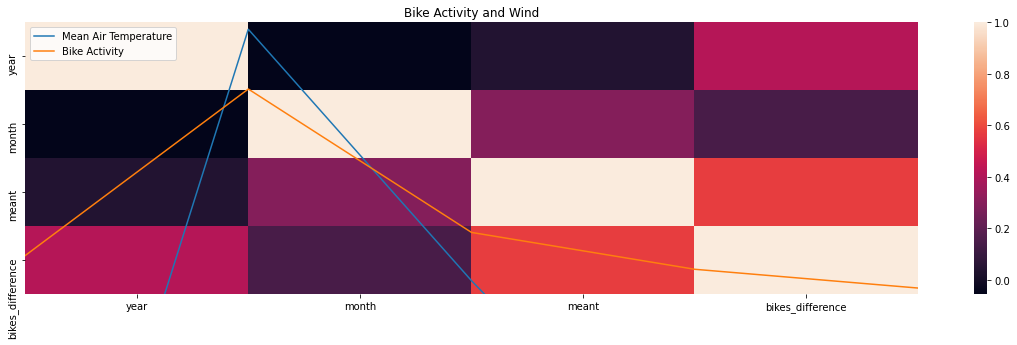

In [ ]:
2. #Bike Activity And Mean Air Temperature

#remove unneeded column
wind.drop(columns='timestamp')

#merge the Mean Air Temperature and Bike Activity columns from the two dataframes
B = pd.merge(wind, B1)

weather_normalized = B['meant']/B['meant'].max()

#pearson coefficient to see the correlation
print("The pearson coefficient for bike_activity and mean air temperature is:", pearsonr(B['bikes_difference'], B['meant']))

#plot the comparison
plt.figure(figsize=(20,5))
plt.title('Bike Activity and Wind')
plt.plot(B['meant'], label="Mean Air Temperature")
plt.plot(B['bikes_difference'], label="Bike Activity")
plt.xlabel('Data Samples')
plt.ylabel('Values')
plt.legend(loc='upper left', frameon=True)

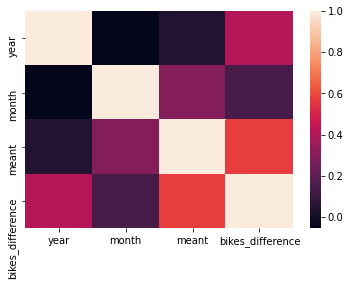

In [ ]:
3. #correlation heatmap - bike activity and mean air temperature
corr = B.corr()
sns.heatmap(corr)

The Pearson Correlation Coefficient is: (-0.1007759129491751, 0.328592072584885)


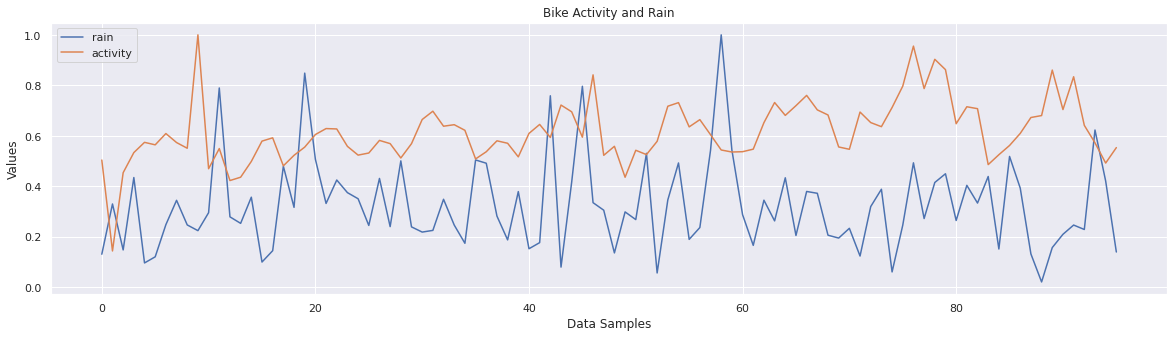

In [20]:
4. #Bike Activity And Rain Plots

#load rain data
rainy_weather = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/phoenix.csv')
rainy_weather = rainy_weather.drop(rainy_weather[rainy_weather.year < 2010].index)

# # Extract out only the data we need.
rainy_weather = rainy_weather.loc[:, ['year', 'month', 'rain']].reset_index(drop=True)
rainy_weather['rain'] = rainy_weather['rain'].astype(str).astype(float)
rainy_data = rainy_weather.groupby(['year', 'month'])['rain'].mean().reset_index()

#combine the 2 features - bike activity and rain
rain_activity = pd.merge(rainy_data, B1)
rain_activity['rain'] =  rain_activity['rain']/rain_activity['rain'].max()
rain_activity['bikes_difference'] =  rain_activity['bikes_difference']/rain_activity['bikes_difference'].max()

#correlation between rain and bike activity
print("The Pearson Correlation Coefficient is:", pearsonr(rain_activity['rain'], rain_activity['bikes_difference']))

#plot the two features - bike activity & rain
plt.figure(figsize=(20,5))
plt.title('Bike Activity and Rain')
plt.xlabel('Data Samples')
plt.ylabel('Values')
plt.plot(rain_activity['rain'], label="rain")
plt.plot(rain_activity['bikes_difference'], label="activity")
plt.legend(loc='upper left', frameon=True)

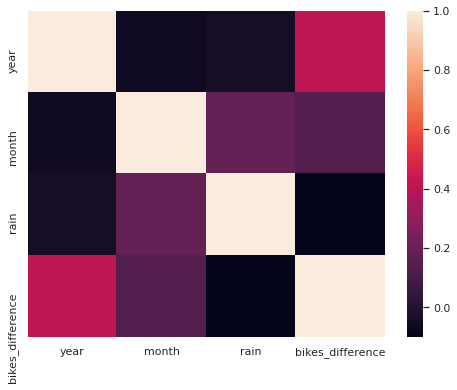

In [25]:
5. #correlation heatmap - bike activity and rain
corr = rain_activity.corr()
plt.figure(figsize = (8,6))
sns.heatmap(corr)

# Employing Prophet Library

In [ ]:
#Employing Prophet Library
activity = grouped_activity[['timestamp', 'bikes_difference']].copy()
values = np.power(activity['bikes_difference'], 2)
activity['bikes_difference'] = values
activity['timestamp'] = pd.to_datetime(activity['timestamp'], format='%Y-%m-%d %H:%M:%S')

#Renaming them as requirement of Prophet Library
activity.rename(columns={'timestamp':'ds'}, inplace=True)
activity.rename(columns={'bikes_difference':'y'}, inplace=True)

# #set index to ds for applying resample function
activity.set_index('ds', inplace=True) 

# #resample by month and sum the values in between that, also fill empty NAN values
activity= activity.resample('M').sum().bfill()

activity[activity.values  == 0] = activity['y'].mean()

# #normalize the values between 0-1
activity= activity/activity.max()

#removing outliers
mean = np.mean(activity['y'], axis=0)
sd = np.std(activity['y'], axis=0)
final_list = [x for x in activity['y'] if (x > mean - 2 * sd)]
final_list = [x for x in final_list if (x < mean + 2 * sd)]
activity = activity[activity['y'].isin(final_list)]

activity

,y
ds,
2010-10-31,0.029546
2010-11-30,0.132280
2010-12-31,0.008545
2011-01-31,0.091001
2011-02-28,0.096724
...,...
2018-09-30,0.153100
2018-10-31,0.121635
2018-11-30,0.101597


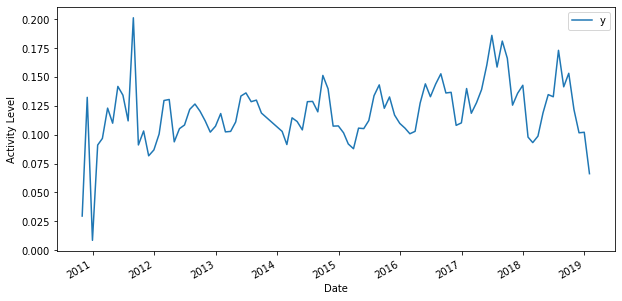

In [ ]:
#3. Plotting the above created table
ax = activity.plot(figsize=(10, 5))
ax.set_ylabel('Activity Level')
ax.set_xlabel('Date')

plt.show()

In [ ]:
#1. predict bike-availability in general for 1 station  - using Prophet Library

my_df = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
my_df = my_df[my_df['tfl_id']==1]

my_df['timestamp'] = pd.to_datetime(my_df['timestamp'], format='%Y-%m-%d %H:%M:%S')

# my_df.isna().sum()

# #keep only first instance of a duplicate row
my_df.drop_duplicates(keep='first')
my_df.dropna(inplace=True)
my_df['percentage_bikes_availability'] = my_df['bikes']/my_df['total_docks']

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
#2. Create 2 columns as requirement of Prophet Library
prof = my_df[['timestamp', 'percentage_bikes_availability']].copy()

#Renaming them as requirement of Prophet Library
prof.rename(columns={'timestamp':'ds'}, inplace=True)
prof.rename(columns={'percentage_bikes_availability':'y'}, inplace=True)

#set index to ds for applying resample function
prof.set_index('ds', inplace=True) 

#resample by month and sum the values in between that, also fill empty NAN values
prof1= prof.resample('M').mean().bfill()

#fill zero values with mean of the column 
prof1[prof1.values  == 0] = prof1['y'].mean()

#normalize the values between 0-1
prof1= prof1/prof1.max()
prof1 * 100

prof1.reset_index(inplace=True)
prof1

,ds,y
0,2010-10-31,0.644809
1,2010-11-30,1.000000
2,2010-12-31,1.000000
3,2011-01-31,0.627220
4,2011-02-28,0.614378
...,...,...
95,2018-09-30,0.662703
96,2018-10-31,0.576823
97,2018-11-30,0.772019
98,2018-12-31,0.730150


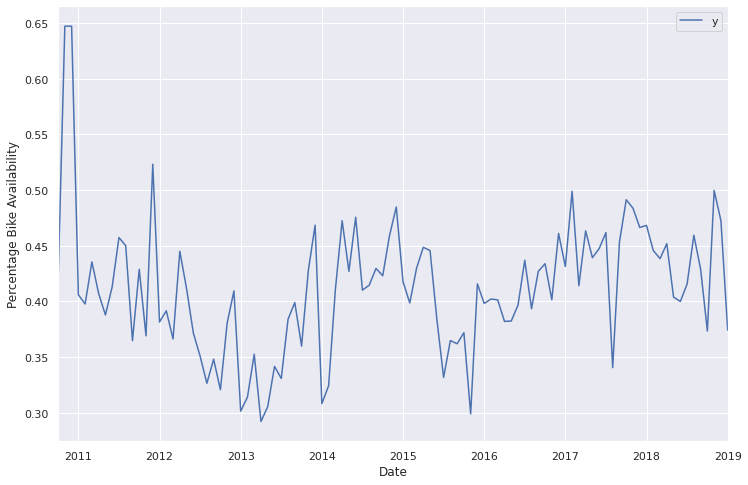

In [ ]:
#3. Plotting the above created table
ax = prof1.plot(figsize=(12, 8))
ax.set_ylabel('Percentage Bike Availability')
ax.set_xlabel('Date')

plt.show()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


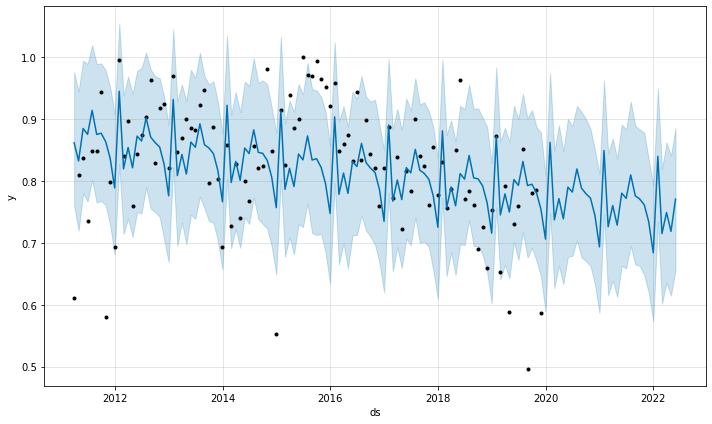

In [ ]:
#predict bike-availability  - from fbprophet import Prophet

#instantiating a new Prophet object
m = Prophet(changepoint_prior_scale=0.01).fit(prof1)

# #Then you call its fit method and pass in the historical dataframe
future = m.make_future_dataframe(periods=30, freq='M')

fcst = m.predict(future)
fig = m.plot(fcst)
fig2 = m.plot_components(fcst)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


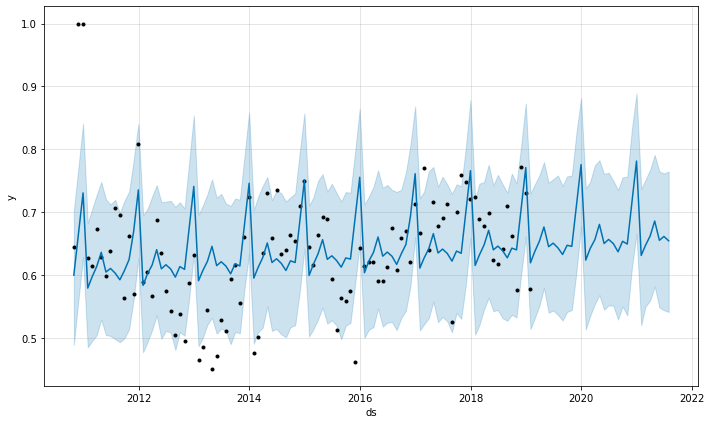

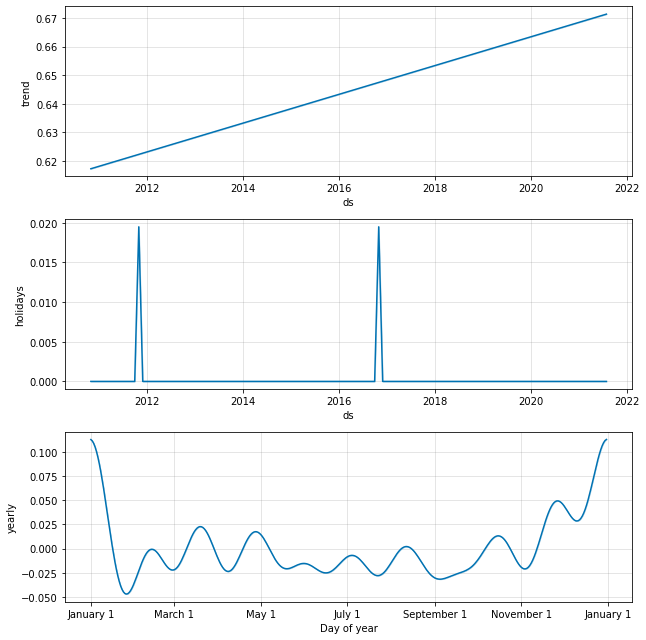

In [ ]:
#Holiday Effects
holidays = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/holidays.csv')
#Renaming them as requirement of Prophet Library
holidays.rename(columns={'Timestamp':'ds'}, inplace=True)
holidays.rename(columns={'Holiday':'holiday'}, inplace=True)

m = Prophet(holidays=holidays, changepoint_prior_scale=0.01)

forecast = m.fit(prof1)

future = m.make_future_dataframe(periods=30, freq='M')

#instantiating a new Prophet object
# m = Prophet(holidays=holidays, changepoint_prior_scale=0.01).fit(prof1)

# #Then you call its fit method and pass in the historical dataframe

fcst = m.predict(future)
fig = m.plot(fcst)
fig2 = m.plot_components(fcst)

In [ ]:
#1. For Time Series - Plot for 2012 data of Station 5: charlemont Place
trend = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')

          tfl_id  bikes  spaces            timestamp  ...  hour  day  month  year
11084661       5     19      21  2015-01-01 02:10:02  ...     2    3      1  2015
11084761       5     19      21  2015-01-01 05:00:01  ...     5    3      1  2015
11084861       5     19      21  2015-01-01 05:10:01  ...     5    3      1  2015
11084961       5     19      21  2015-01-01 06:10:02  ...     6    3      1  2015
11085061       5     19      21  2015-01-01 06:20:01  ...     6    3      1  2015
...          ...    ...     ...                  ...  ...   ...  ...    ...   ...
16223101       5      2      38  2015-12-31 23:10:02  ...    23    3     12  2015
16223199       5      2      38  2015-12-31 23:20:01  ...    23    3     12  2015
16223297       5      2      38  2015-12-31 23:30:02  ...    23    3     12  2015
16223395       5      2      38  2015-12-31 23:40:02  ...    23    3     12  2015
16223493       5      2      38  2015-12-31 23:50:02  ...    23    3     12  2015

[51324 rows x 9

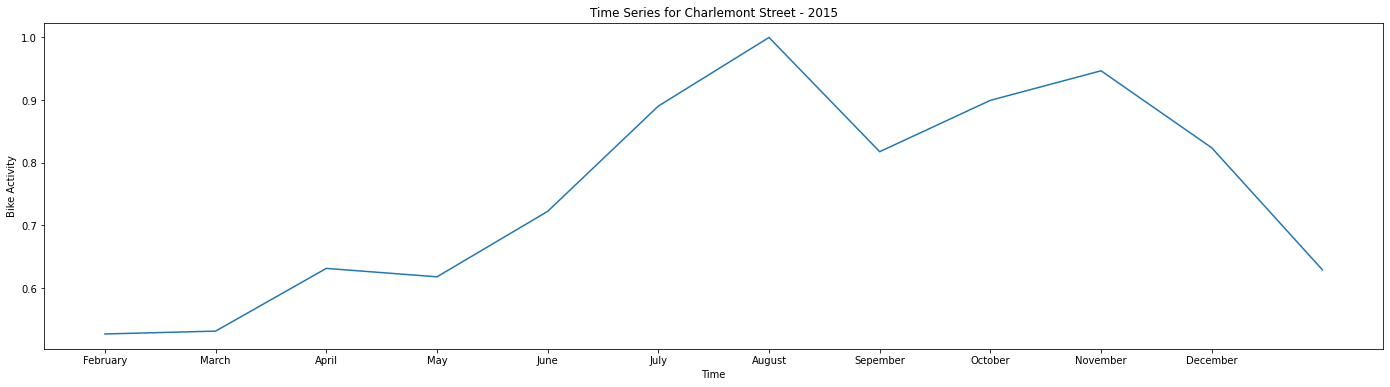

In [ ]:
#2. For Time Series - Plot for 2012 data of Station 5: charlemont Place

# Function to square groupedby results
def square_list(x):
    return (x**2).mean()

trend_charlemont = trend[trend['tfl_id']==44]
trend_ = trend_charlemont[trend_charlemont['year']==2015]

print("Bike Station:", trend_['tfl_id'].values[0], " - Trend for the year:",trend_['year'].values[0], "\n" )

# #subtract each row bike value from prev bike value to get each 10-min bike difference in each hour
trend_['bikes_difference'] = trend_['bikes'].diff(periods=-1)

trend_.dropna(inplace=True)

# #take squared sum of the bike difference values for every hour of every day (Mon-Sun) (since our bike difference was previously for each 10 min interval)
grouped_trend = pd.DataFrame(trend_.groupby(['month'])['bikes_difference'].apply(square_list))

# # Normalize bike difference values
grouped_trend = grouped_trend/grouped_trend.max()

# #resetting the index (serial numbering on left in dataframe since some rows were dropped)
# # grouped_multiple is now the normalized hourly bike-difference/fluctuation/activity level for every week day (regardless of year)
grouped_trend = grouped_trend.reset_index()
print(grouped_trend)

trend_data = pd.DataFrame()
# #for every single day (Mon-Sun), we should have an hourly bike-diff value on a flat list for heat map
trend_data = grouped_trend.apply(list)

time = pd.to_datetime(trend[['year', 'month']].assign(DAY=1))

trend_data

plt.figure(figsize=(24,6))
plt.title('Time Series for Upper Sherard Street - 2015')
plt.xlabel('Time')
plt.ylabel('Bike Activity')
plt.xticks(np.arange(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Sepember', 'October', 'November', 'December'])  # Set text labels.
plt.plot(trend_data['month'], trend_data['bikes_difference'])
plt.show()

# #create values from 0-23 in form of a list of strings i.e ['0', '1',...'23']
# cols = list(map(str, range(24)))

# final1[cols] = pd.DataFrame(final.to_list(), index=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
# # final1 now has a bike difference annot for each cell in the heatmap, i.e. hour on x-axis, day on y-axis and a value in cell showing bike-diff/fluctuation at a specific hour within a specific day - matrix
# plt.figure(figsize=(14,6))
# # sns.heatmap(final1)

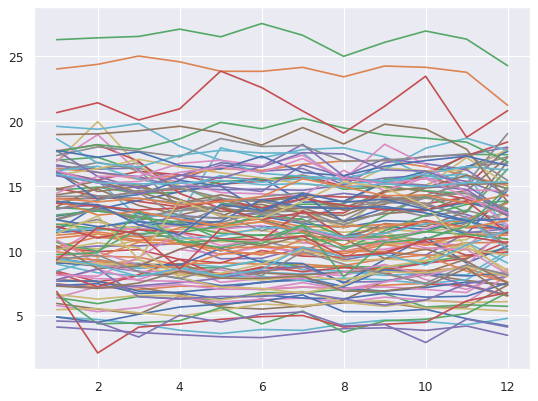

In [14]:
#Plot of bike availability according to tfl_id/station on a 10 year data (unormalized)
df = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')
temp = df.copy()

plots = []
for tfl_id in range(1,temp['tfl_id'].max()):
  temp1 = temp[temp['tfl_id']==tfl_id]
  
  temp1 = temp1.groupby('month')['bikes'].mean()
  # print(temp1.shape)
  plots.append(temp1)

# f, axes = plt.subplots(len(plots), 1)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(len(plots)):
  plt.plot(plots[i])

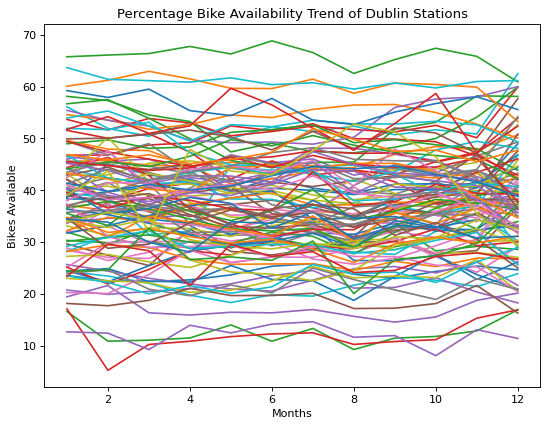

In [ ]:
#Plot of bike availability according to tfl_id/station on a 10 year data (normalized)
temp = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/combined.csv')

#normalizing the data
temp['bikes']= (temp['bikes']/temp['total_docks']) * 100

plots = []
for tfl_id in range(1,temp['tfl_id'].max()):
  temp2 = temp[temp['tfl_id']==tfl_id]
  temp2 = temp2.groupby('month')['bikes'].mean()
  plots.append(temp2)

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Percentage Bike Availability Trend of Dublin Stations')
plt.xlabel('Months')
plt.ylabel('Bikes Available')
for i in range(len(plots)):
  plt.plot(plots[i])

In [ ]:
#check for correct number of plots - should be equal to number of bike stations
print (len(plots))
print (len(plots[0]))

# Bike Locations File

In [17]:
# 'bikelocations_dublin.csv' = Individual Docking Stations

bike_locations = pd.read_csv('/content/drive/My Drive/Dublin Bike Analysis/bikelocations_dublin.csv')

# Capitalising operator names column to have a standardised naming
bike_locations['operator_name'] = bike_locations['operator_name'].str.upper()

# Dropping 'notes','system','operator_installflag','operator_tempflag','operator_lockflag' and 'pedelec' columns since they have useless data
bike_locations = bike_locations.drop(columns=['operator_intid', 'operator_altid', 'notes','system','operator_installflag','operator_tempflag','operator_lockflag','pedelec'])

bike_locations.rename(columns={'ucl_id': 'tfl_id'}, inplace=True)

#confirm the types of each column
# bike_locations.dtypes

#check for any null values
# bike_locations.isnull().sum()

#clean repeated or relocated bike stations - remove Chatham Street, Charlemonth Place, remove entries with ids 0, remove bracket entries with unique lat, lon
bike_locations = bike_locations.drop(bike_locations[bike_locations["operator_name"] == 'CHATHAM STREET'].index)
bike_locations = bike_locations.drop(bike_locations[bike_locations["operator_name"] == 'CHARLEMONT STREET'].index)
bike_locations = bike_locations.drop(bike_locations[bike_locations['operator_name'].str.contains('GPO')].index)
bike_locations = bike_locations.drop(bike_locations[bike_locations["operator_name"] == 'PORTABELLO ROAD'].index)
bike_locations.drop_duplicates(['operator_name'], keep='first', inplace=True)
bike_locations.drop_duplicates(['lat', 'lon'], keep='last', inplace=True)
bike_locations.reset_index(drop=True, inplace=True)

#nitial_bikes	initial_size	curr_bikes
bike_locations = bike_locations.drop(bike_locations[(bike_locations['initial_bikes'] == 0) & (bike_locations['initial_size'] == 0)].index)
bike_locations['geolocation'] = list(zip(bike_locations['lat'], bike_locations['lon'])) #unncessary

#drop NaNs
bike_locations.dropna(inplace=True)

#check for zeros or false values in columns
# bike_locations.all()

pd.set_option("display.max_rows", None)
bike_locations.head()
# bike_locations.to_csv('/content/drive/My Drive/Dublin Bike Analysis/bike_locations_processed.csv', index=False)


,tfl_id,operator_name,lat,lon,initial_bikes,initial_size,curr_bikes,curr_size,created_dt,updated_dt,updated_dt_nonzerobikes,geolocation
0,1,CLARENDON ROW,53.340927,-6.262501,23,31,0,31,2017-05-10 10:42:01,2019-01-19 10:14:02,2019-01-19 08:22:02,"(53.340927, -6.262501)"
1,2,BLESSINGTON STREET,53.356769,-6.268140,6,20,0,20,2010-10-08 01:00:00,2019-11-21 13:16:07,2019-11-21 12:46:08,"(53.35676899999999, -6.26814)"
2,3,BOLTON STREET,53.351182,-6.269859,2,20,7,20,2010-10-08 01:00:00,2019-11-21 13:16:07,2019-11-21 13:16:07,"(53.351181999999994, -6.269858999999999)"
3,4,GREEK STREET,53.346874,-6.272976,2,15,16,20,2010-10-08 01:00:00,2019-11-21 13:16:07,2019-11-21 13:16:07,"(53.346874, -6.272976)"
4,5,CHARLEMONT PLACE,53.330662,-6.260177,33,40,2,40,2015-01-12 21:14:02,2019-11-21 13:16:07,2019-11-21 13:16:07,"(53.330662, -6.260177)"


# Heatmaps and detecting hotspots using Folium

In [19]:
 # Plot all docking station geoloactions

m = folium.Map(location=bike_locations[['lat','lon']].mean().values.tolist(), zoom_start=13)
m.save('map.html')

for index, point in bike_locations.iterrows():
    folium.CircleMarker(point[['lat','lon']], radius=13, fill_color="#3db7e4", popup=point['operator_name']).add_to(m)

# convert to (n, 2) nd-array format for heatmap
stationArr = bike_locations[['lat', 'lon']].to_numpy()

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=13))
m

In [ ]:
#heatmap showing stations with maximum current bikes
for_map = bike_locations
# for_map['percentage_available'] = (for_map['curr_bikes']/for_map['curr_size']) * 100
max_amount = float(for_map['curr_size'].max())

hmap = folium.Map(location=bike_locations[['lat','lon']].mean().values.tolist(), zoom_start=13)

for index, point in bike_locations.iterrows():
    folium.CircleMarker(point[['lat','lon']], radius=13, fill_color="#3db7e4", popup=point['operator_name']).add_to(hmap)

hm_wide = HeatMap( list(zip(for_map.lat.values, for_map.lon.values, for_map.curr_bikes.values)),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )

hmap.add_child(hm_wide)
hmap

# Unit Testing on self-defined functions

If run successfully then the unit test doesn't throw any error.

In [26]:
def squared_row_difference(x):
    x = x.diff(periods=-1)
    return (x*x).mean(skipna=True)

df1 = pd.DataFrame({'A':[1,2,3,4]})
expected_res=pd.Series({'A': 1}).astype(float) #function result should be 1, if not, throws an error

pd.testing.assert_series_equal(df1.apply(squared_row_difference),expected_res,check_names=False)

In [27]:
def square_list(x):
    return (x**2).mean()

df1 = pd.DataFrame({'A':[1,2,3,4]})
expected_res=pd.Series({'A': 7.5}).astype(float) #function result should be 7.5, if not, throws an error

pd.testing.assert_series_equal(df1.apply(square_list),expected_res,check_names=False)